These are plots comparing
 * Shortfall as computed from `DM_LINE_ITEMS`
 * Anticipated shortfall as computed for `m_inflight_fulfillment`
 * Backfilled Inflight Fulfillment predictions

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import datetime 
import numpy as np
import os
import sys
from plotnine import *

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
import pandas as pd
pd.set_option('display.max_rows',500)

import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

In [4]:
START_DATE = '2021-06-01'
END_DATE = '2021-09-30'

qry = f"""
    select m.*,
      concat('Farm ',farm_id) as farm_str
    from predict.m_inflight_fulfillment m
    where fact_date between '{START_DATE}' and '{END_DATE}'
      and is_backfill = true
      and code_version = '1.0.6'
      and computed_at > '2022-07-22 13:00:00'
      and computed_at < '2022-07-22 16:00:00'
"""

data_df = pd.read_sql(qry,conn)

In [5]:
def trend_plot(df, FARM_ID, COMPONENT_ID, PREDICTION_DAYS_AHEAD, TARGET_DATE=None):
    START_DATE = '2021-06-01'
    END_DATE = '2021-09-30'
    
    if len(data_df) < 5:
        return None
    
    COMPONENT_NAME = df.query(f"COMPONENT_ID=={COMPONENT_ID}")['COMPONENT_NAME'].iloc[0]
    
    g = (
        df
        .query(f'FARM_ID == {FARM_ID}')
        .query(f'COMPONENT_ID == {COMPONENT_ID}')
        .query(f'PREDICTION_DAYS_AHEAD == {PREDICTION_DAYS_AHEAD}')

        .filter(items=['FACT_DATE','SHORTFALL_LBS','ANTICIPATED_SHORTFALL_LBS',
                       'PREDICTED_SHORTFALL_LBS_Q10','PREDICTED_SHORTFALL_LBS_Q50','PREDICTED_SHORTFALL_LBS_Q90'
                      ])

        .assign(FACT_DATE = lambda x: pd.to_datetime(x['FACT_DATE']))


        .pipe(lambda df: pd.melt(df, id_vars='FACT_DATE'))
        .assign(value = lambda x: x['value'].astype(float))

        .pipe(lambda df: ggplot(df, aes(x='FACT_DATE',y='value',color='variable'))
              + geom_line()
              + theme(axis_text_x=element_text(hjust=1,rotation=45),
                     figure_size=(15,9))
              + geom_hline(yintercept=100,color='green')
              + ggtitle(f"Farm {FARM_ID}\n{COMPONENT_ID}. {str(COMPONENT_NAME)}\nPredicting {PREDICTION_DAYS_AHEAD} days ahead\nShortfall Calculations vs Predicted Shortfall\n{START_DATE} -- {END_DATE}\n(green line at 100)")
             )
    )
    
    if TARGET_DATE:
        g += geom_vline(xintercept=TARGET_DATE,color='red')

    return g

# Farm 1

In [6]:
FARM_ID = 1

In [7]:
plots = []
for cmp_id in [x for x in sorted(data_df.query(f"FARM_ID=={FARM_ID}")['COMPONENT_ID'].unique().tolist()) if x not in [2,3,5,13,28,39,43,44,45,46]]:
    try:
        gg = trend_plot(data_df, FARM_ID, cmp_id, 1)
        plots.append(gg)
    except Exception as e:
        print(e)
        continue
    

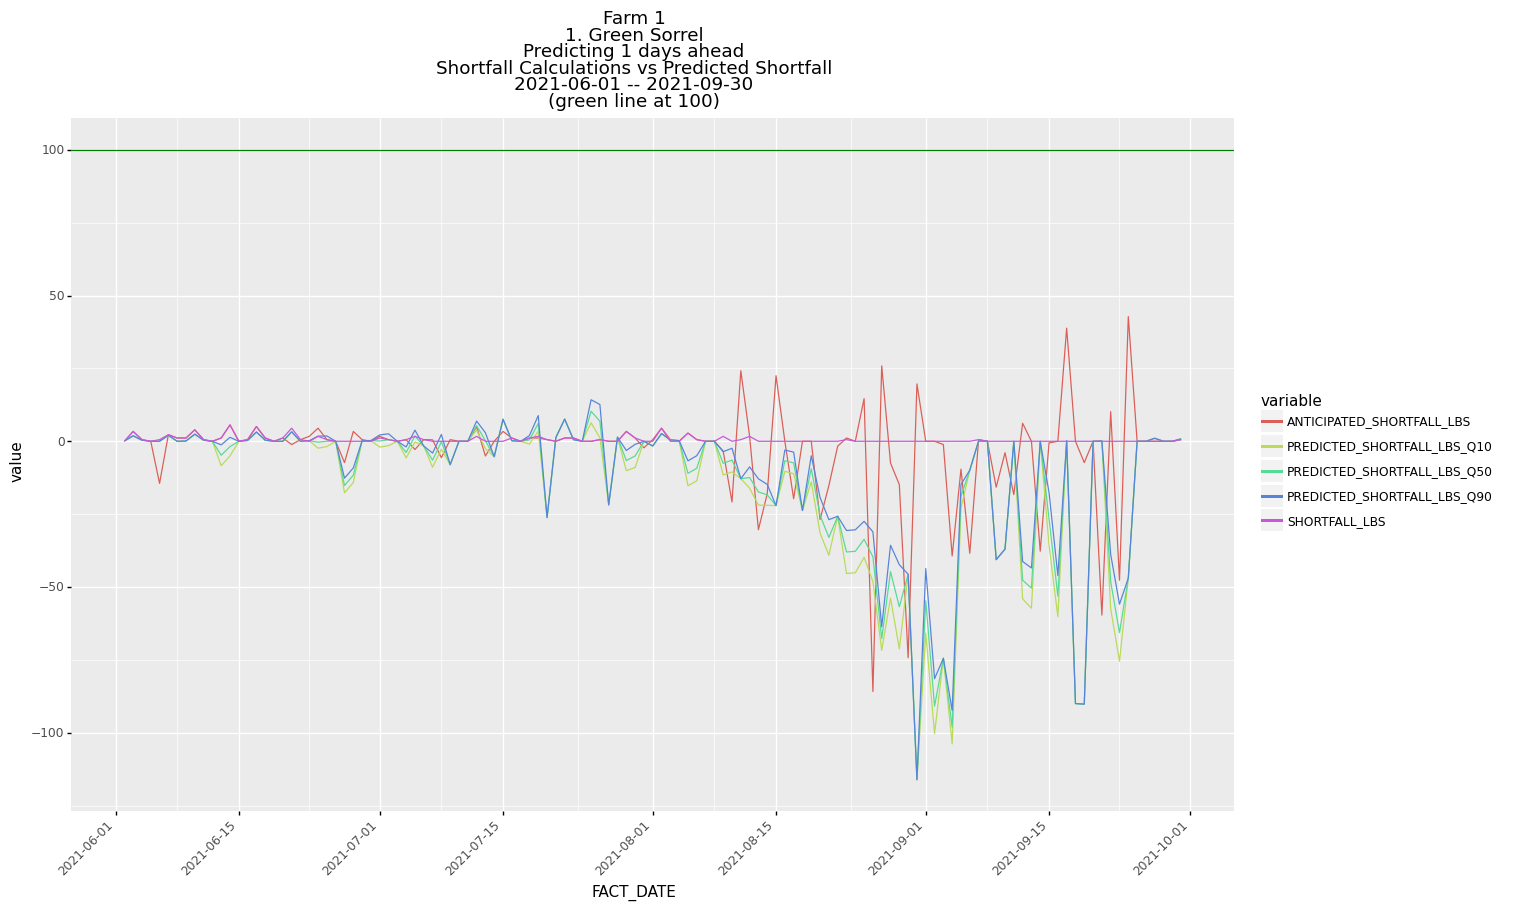

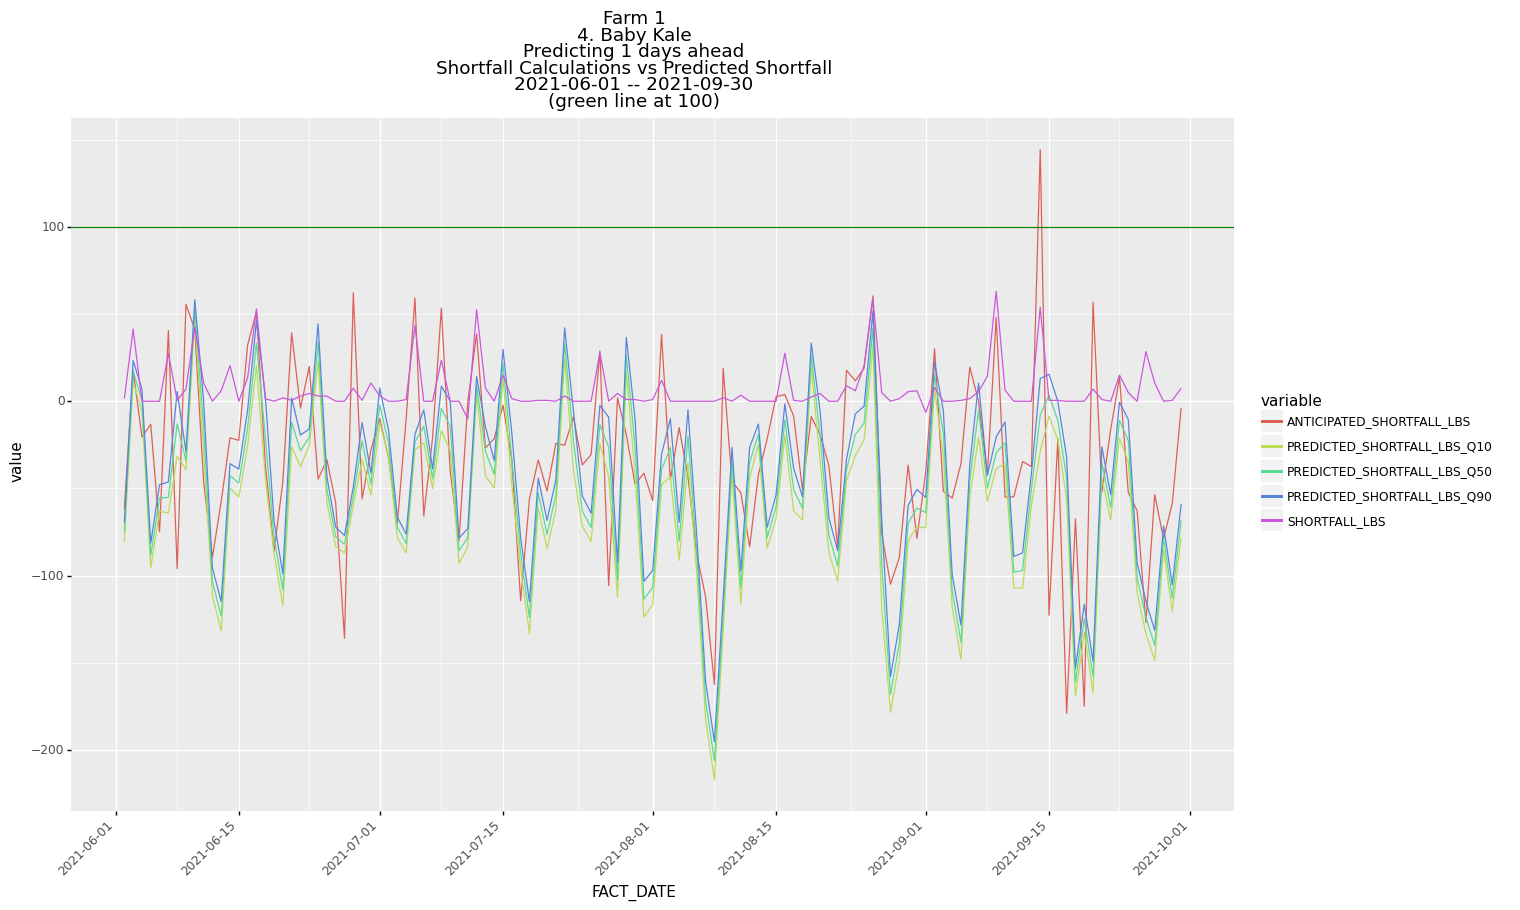

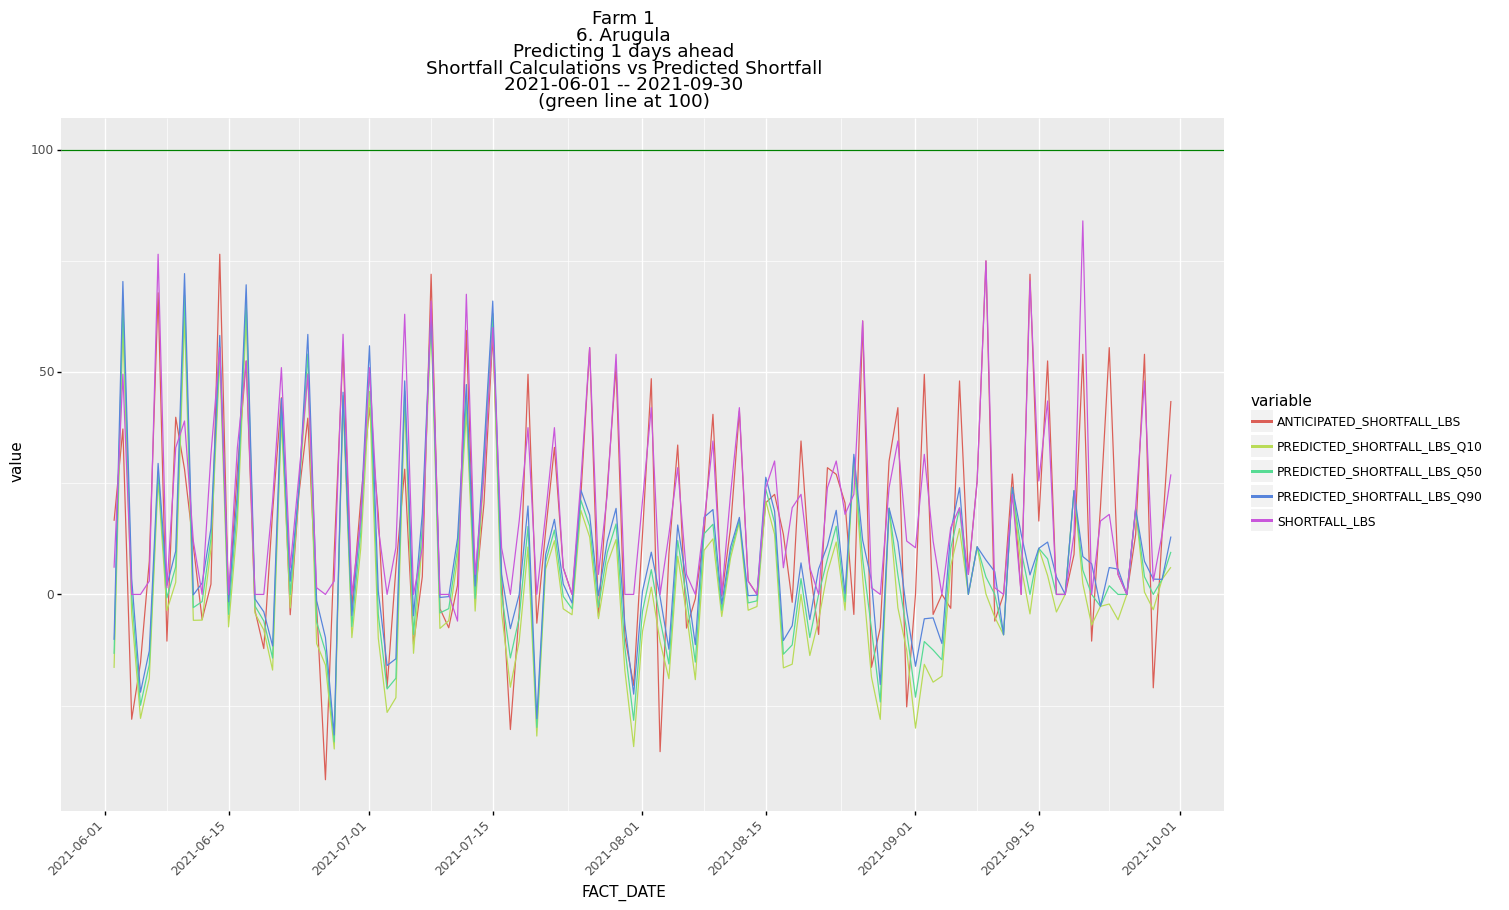

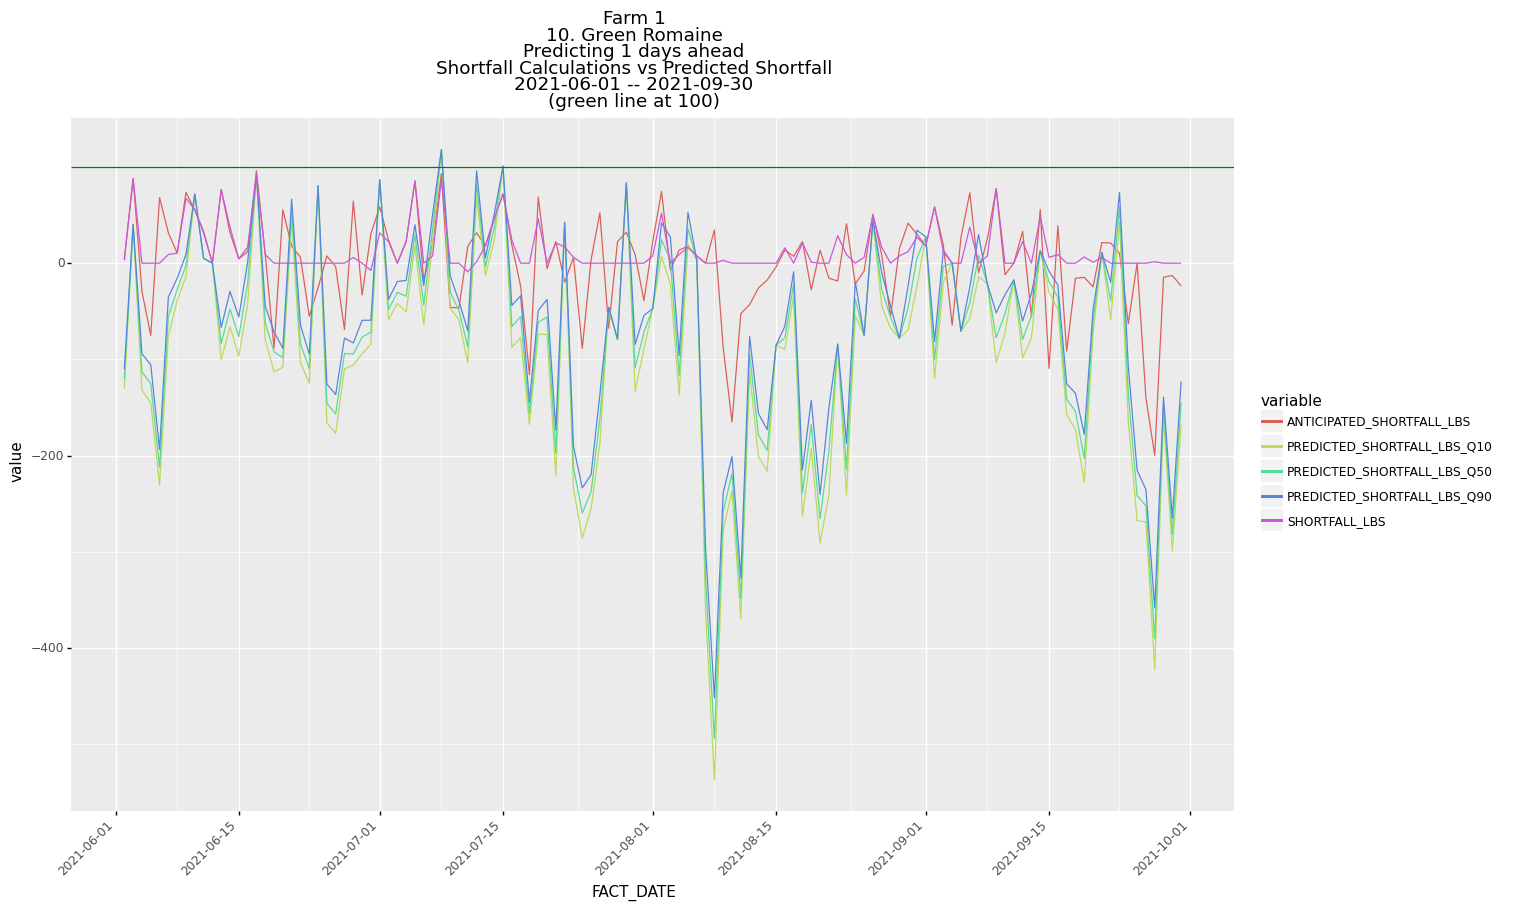

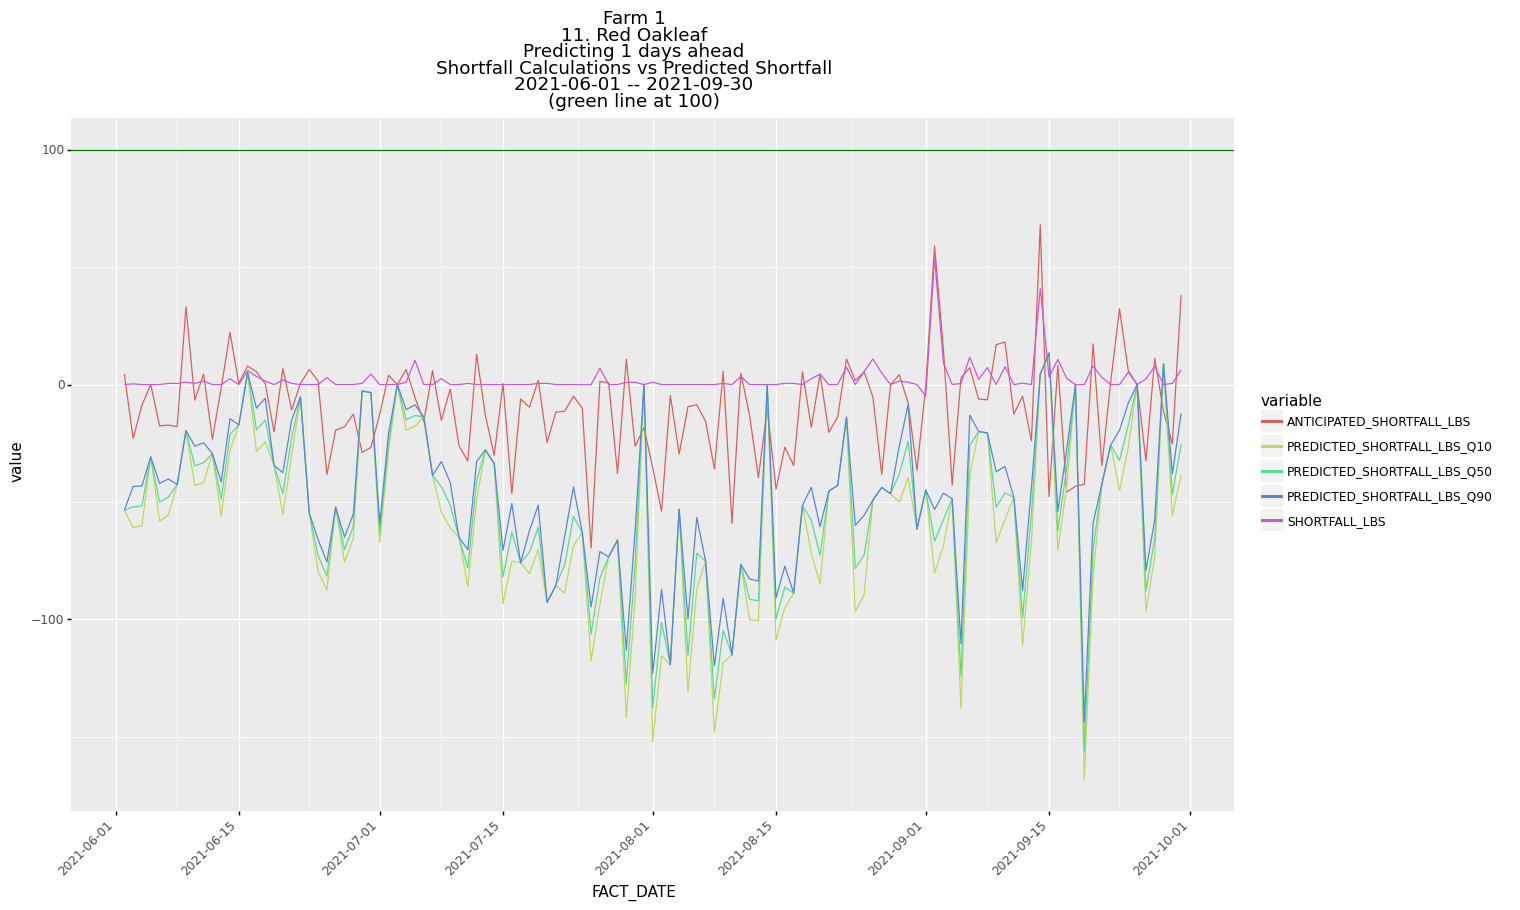

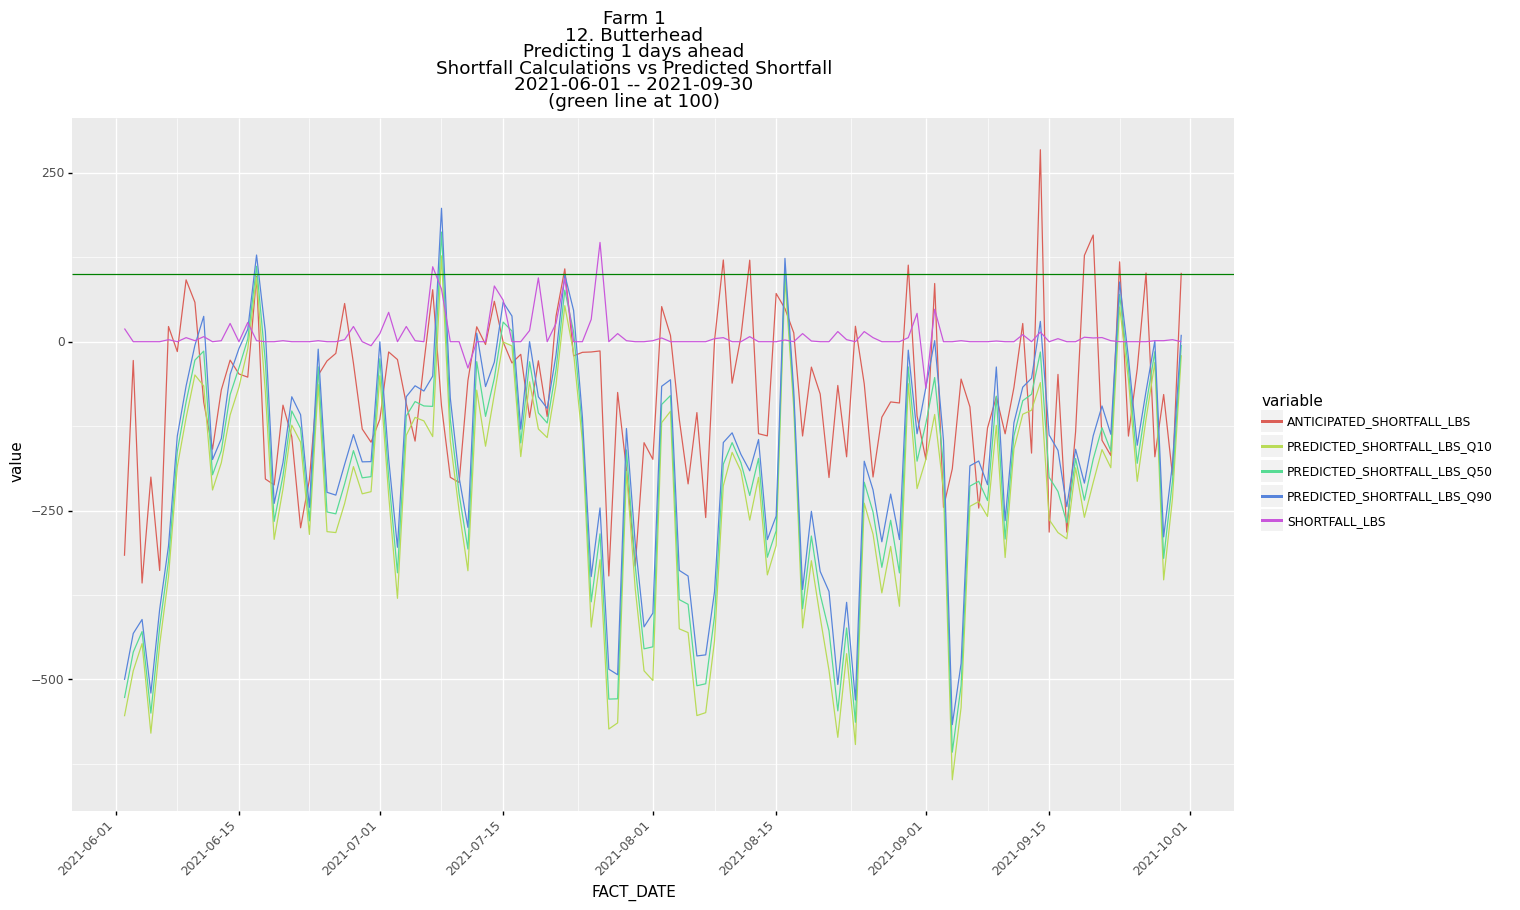

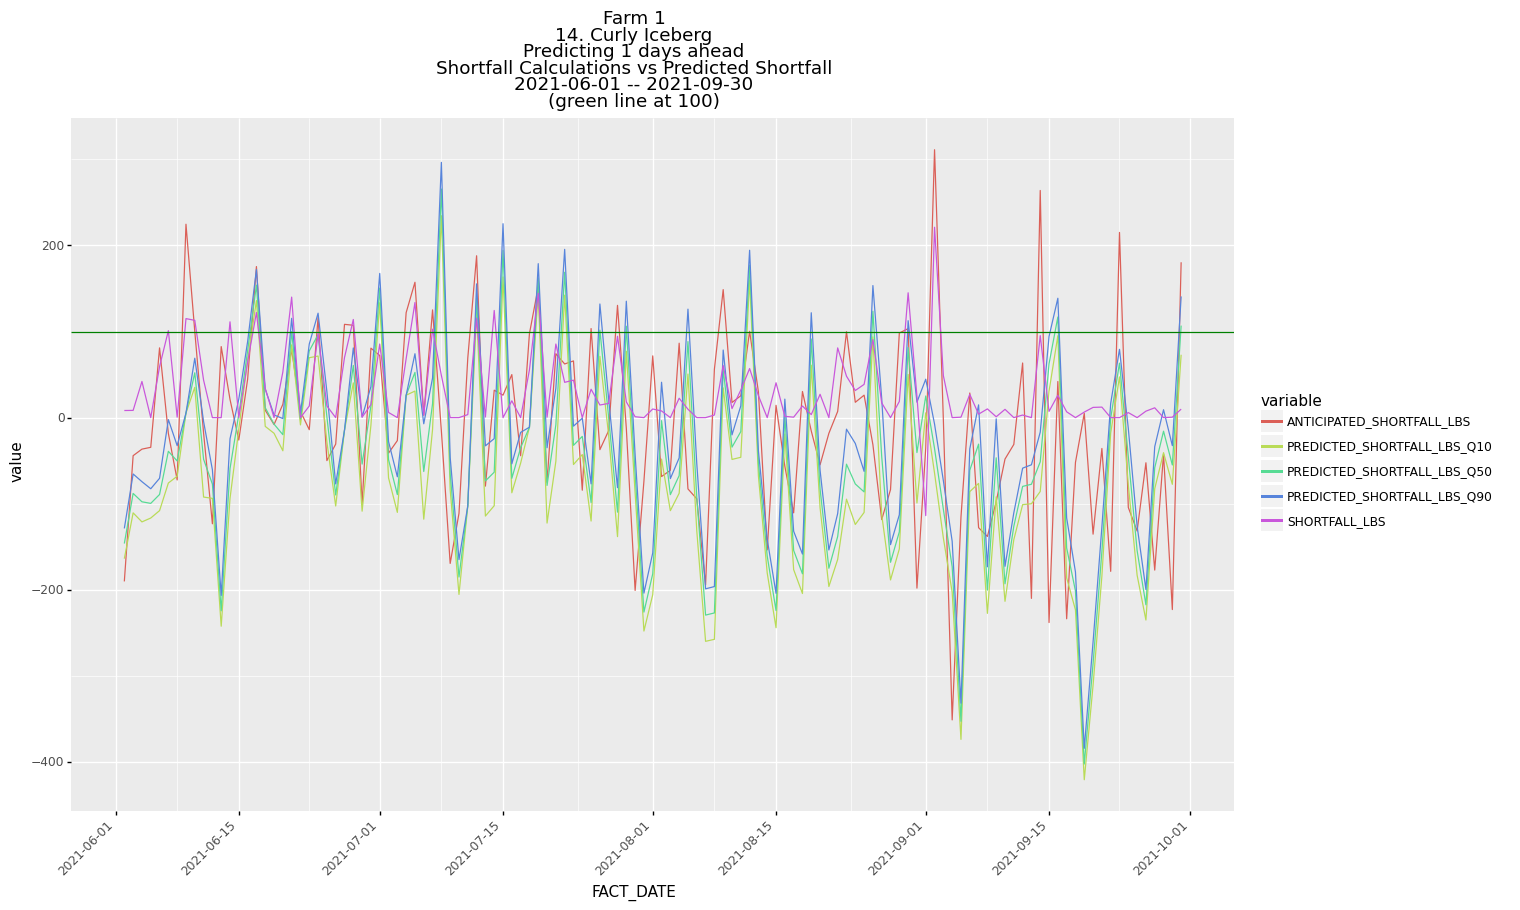

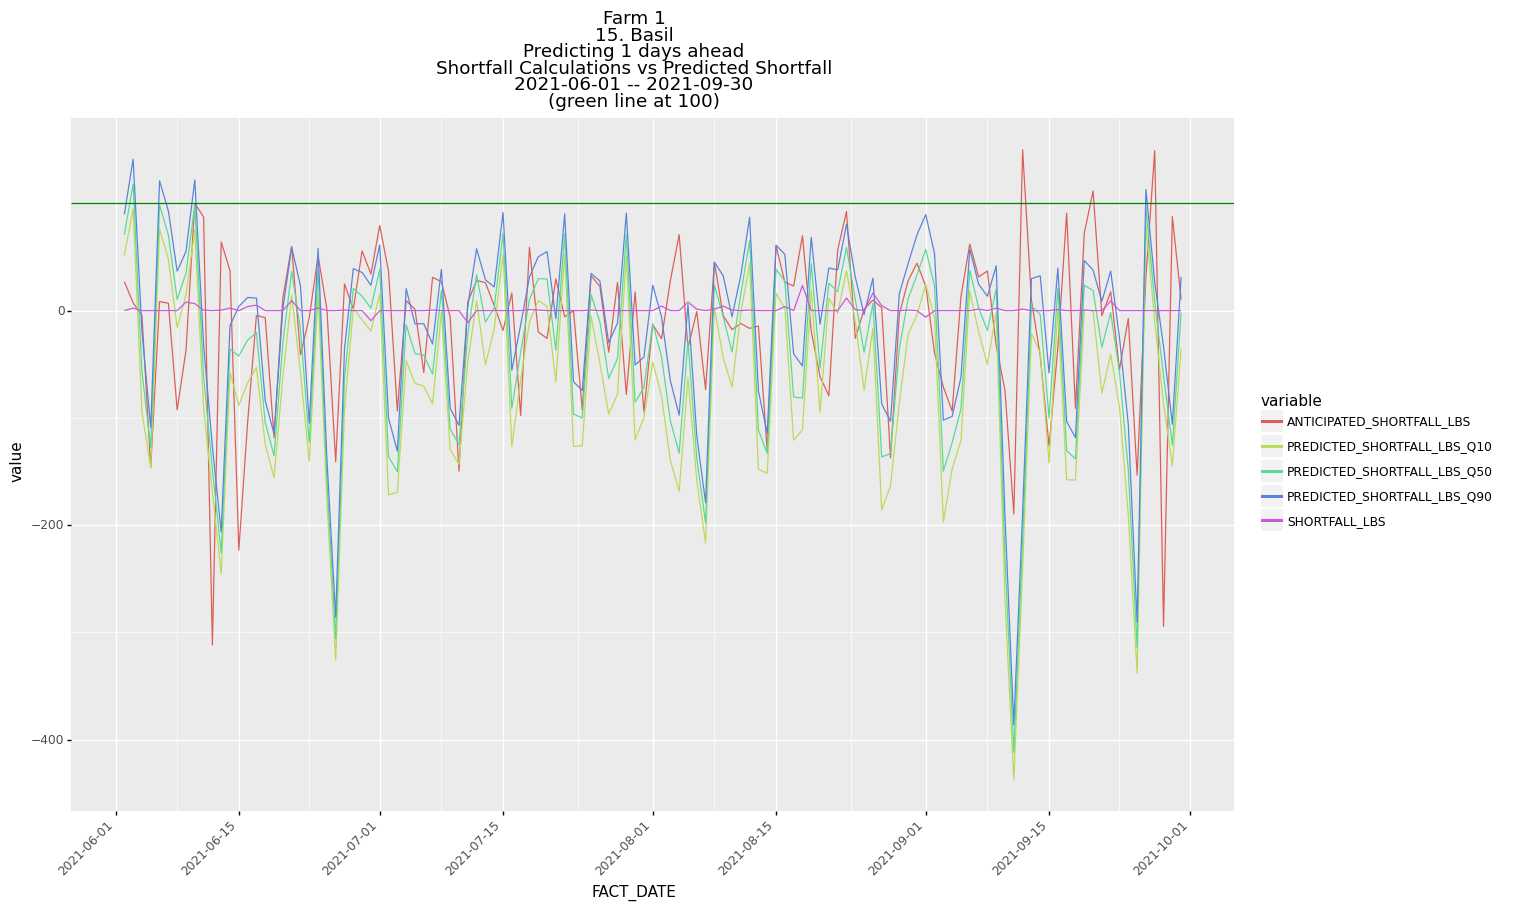

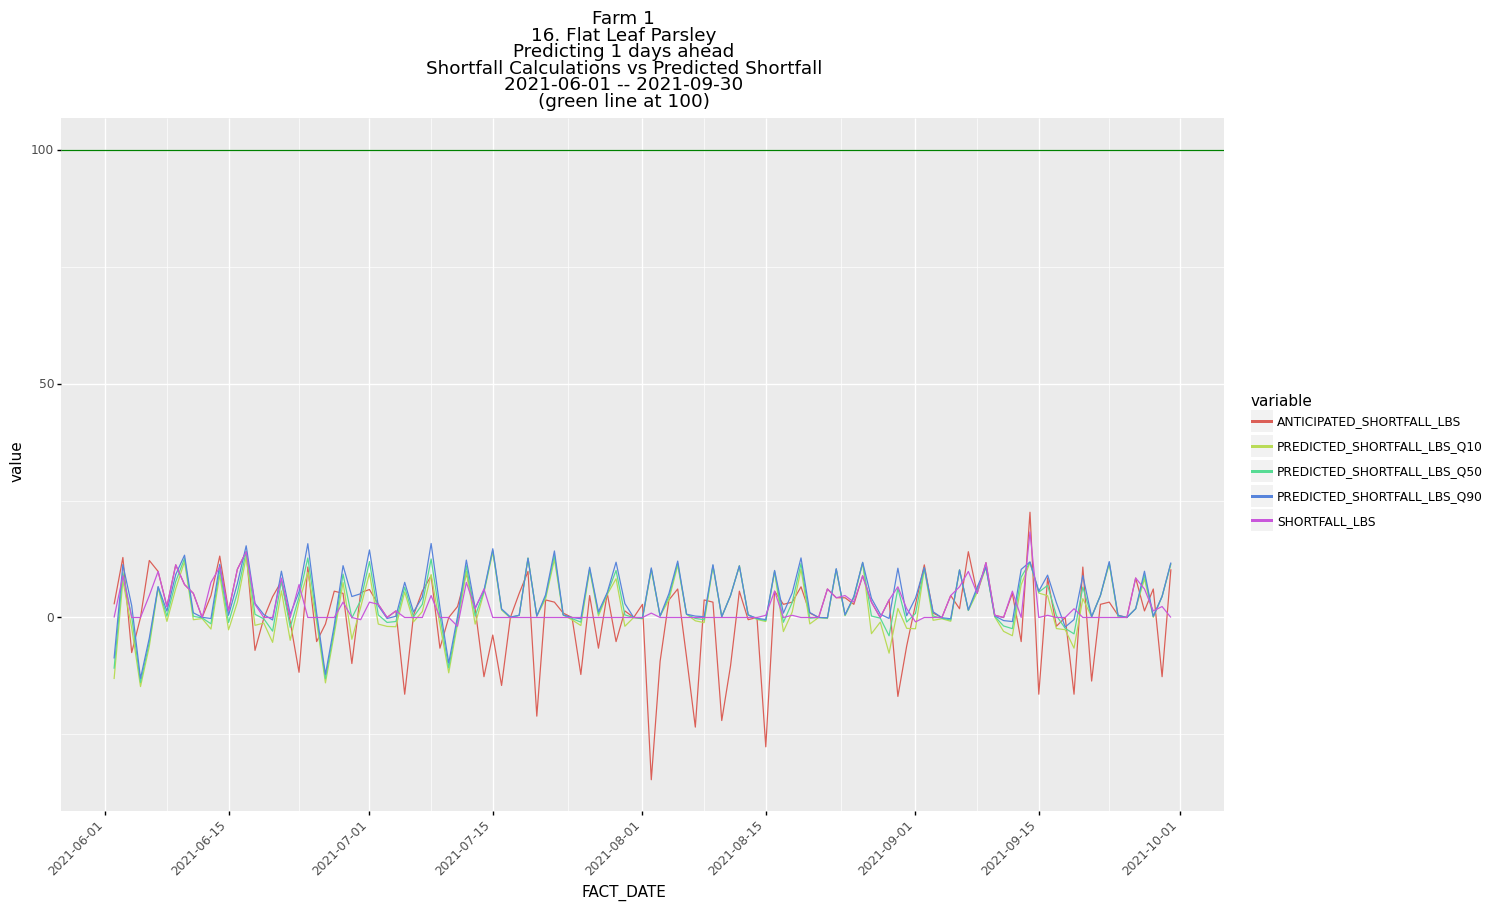

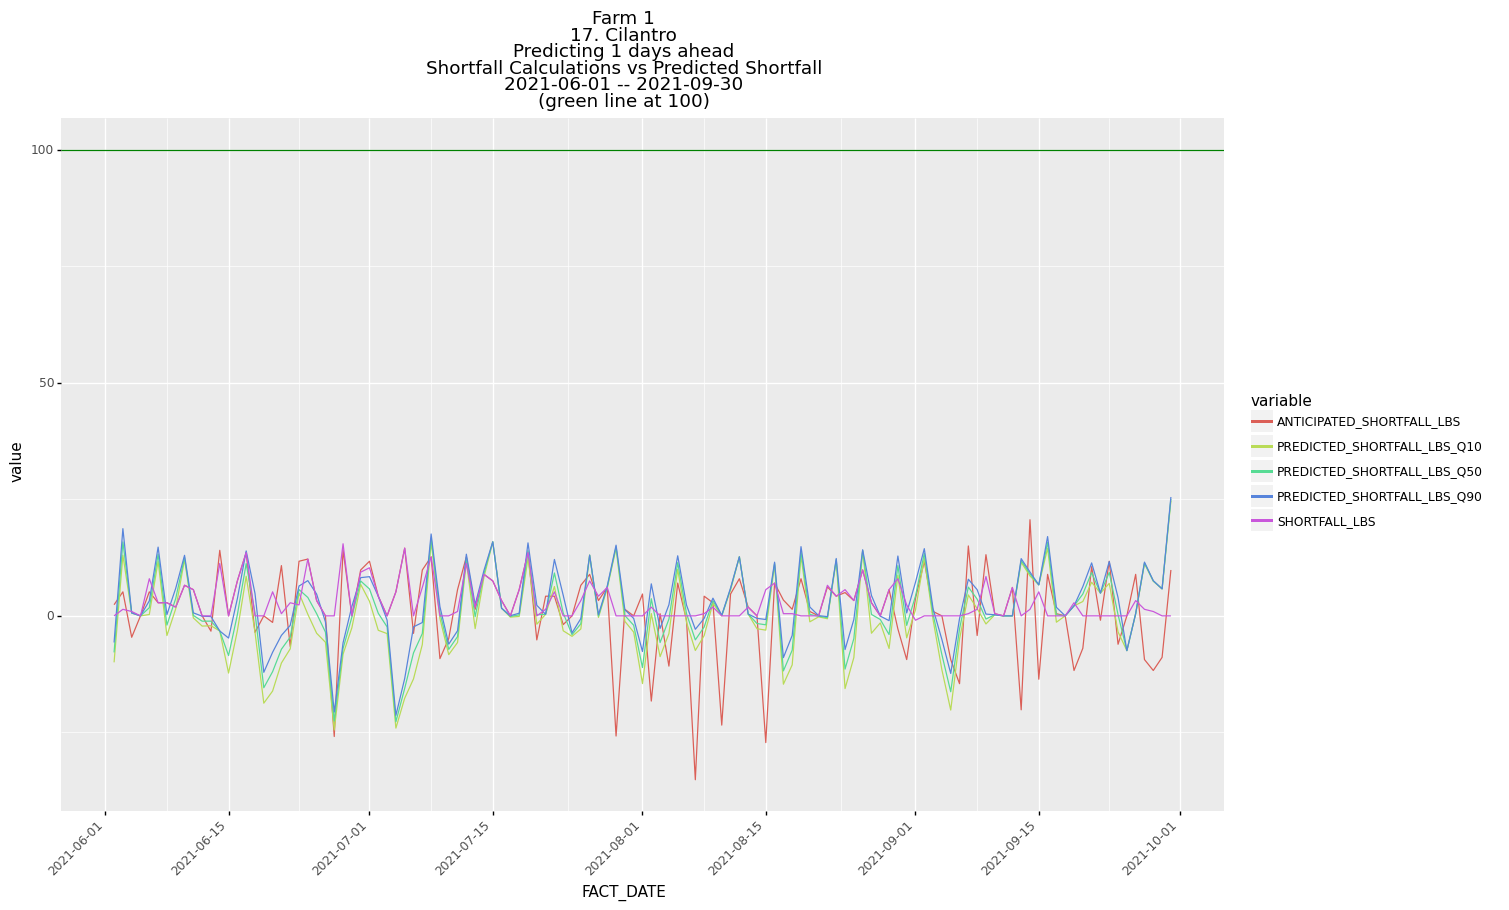

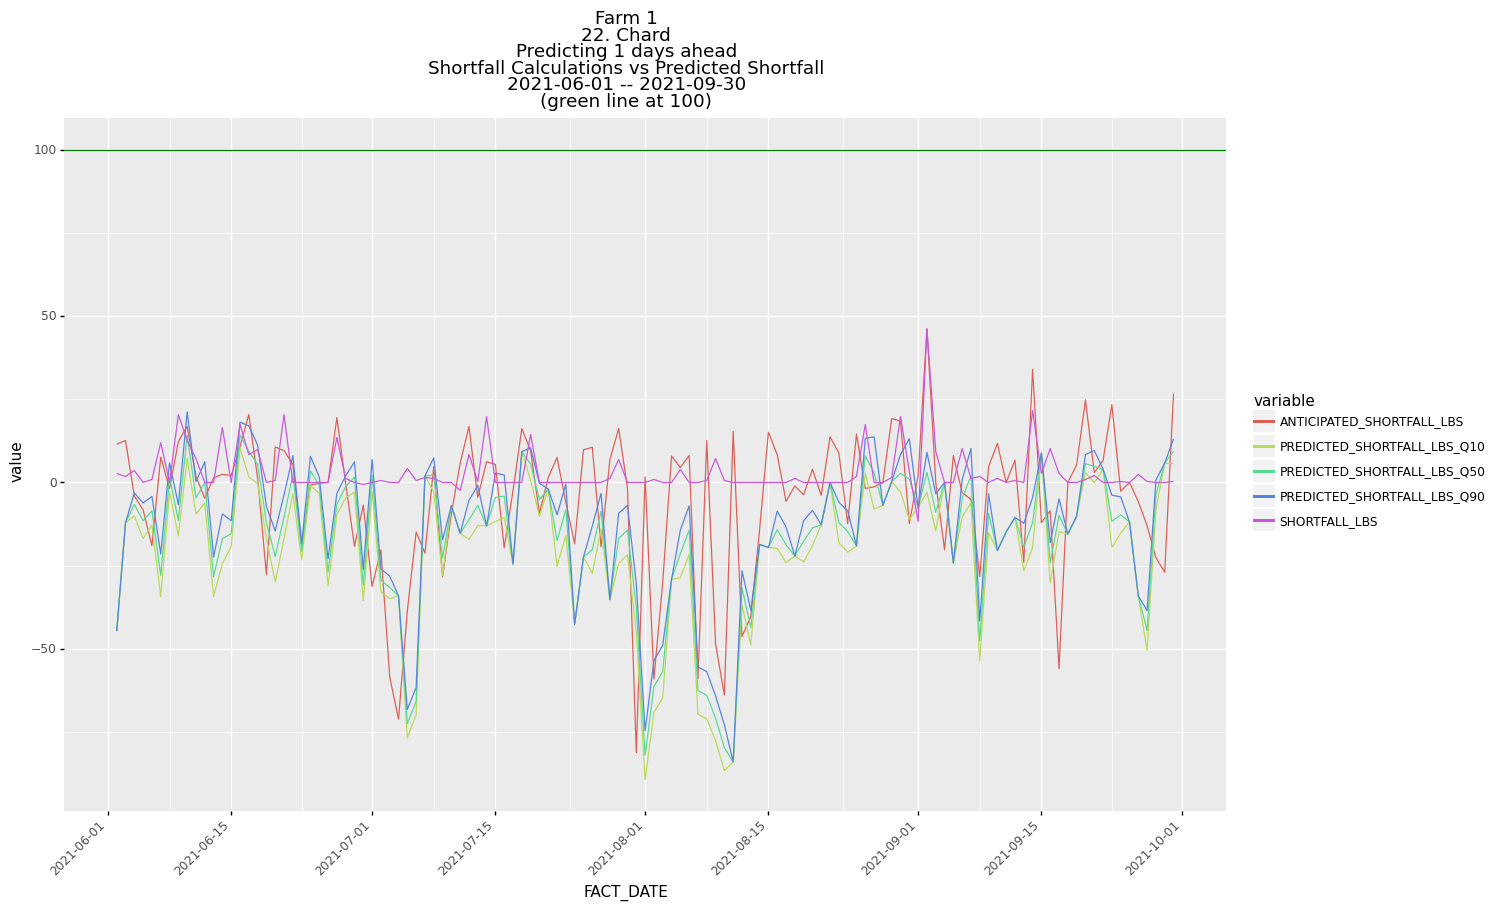

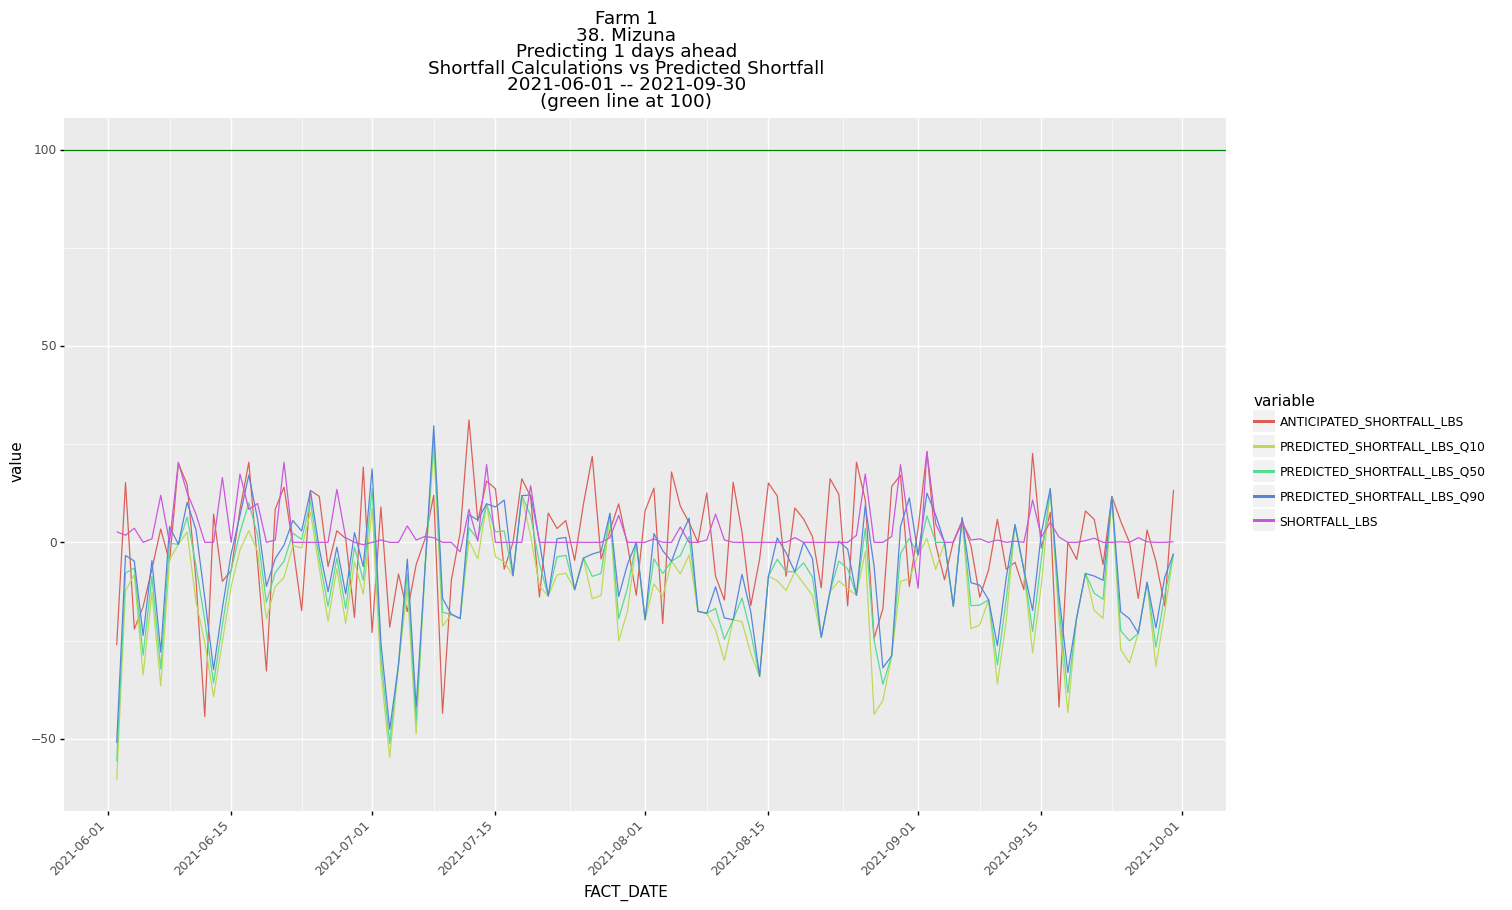

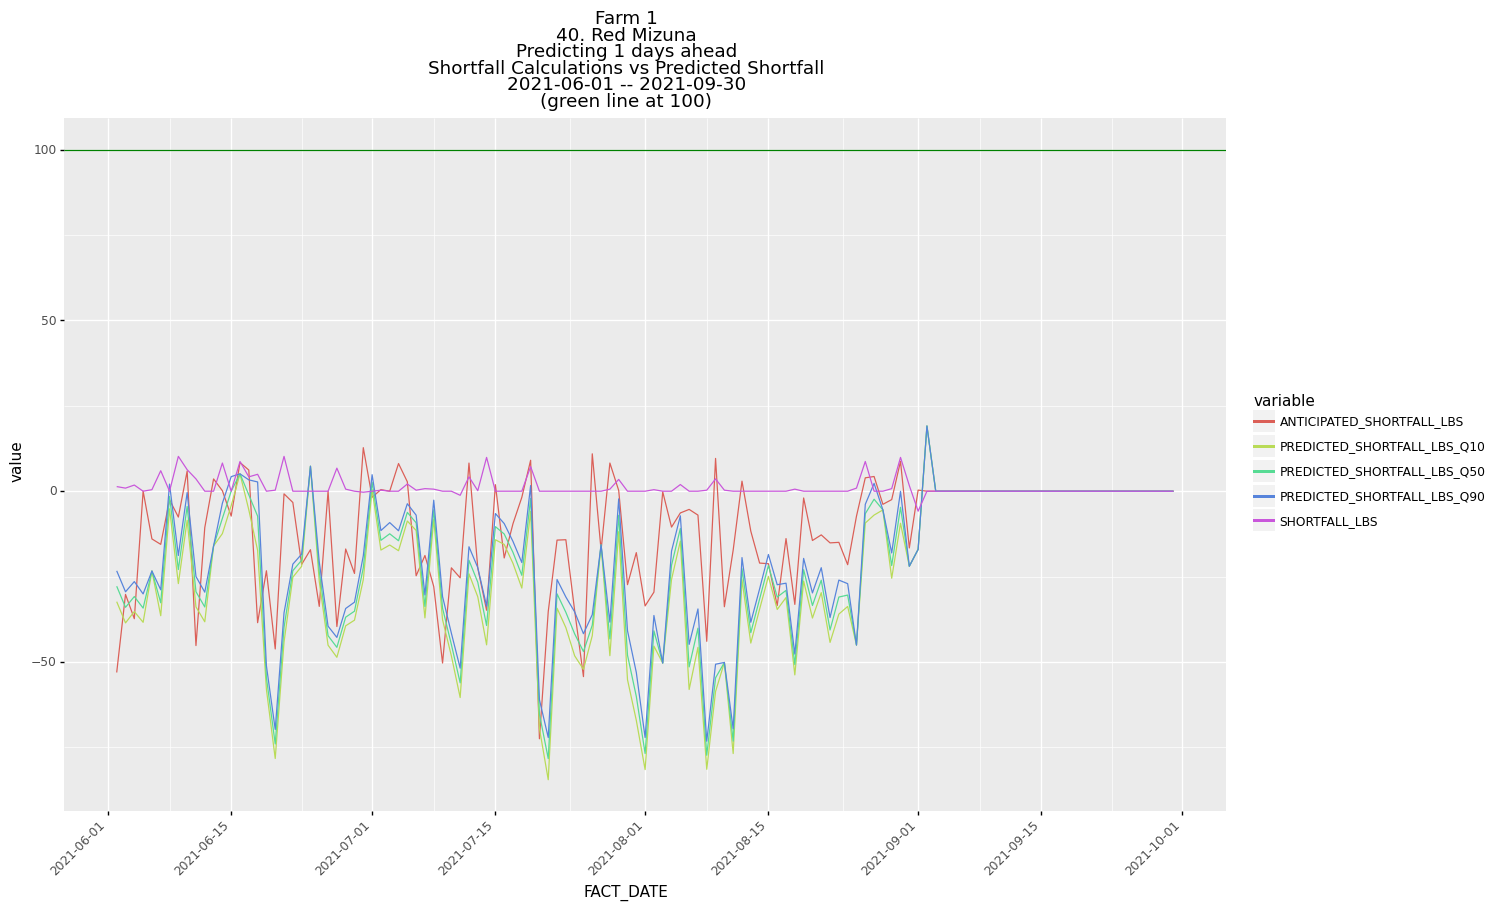

In [9]:
for p in plots:
    print(p)

# Farm 2

In [10]:
FARM_ID = 2

In [11]:
plots = []
for cmp_id in [x for x in sorted(data_df.query(f"FARM_ID=={FARM_ID}")['COMPONENT_ID'].unique().tolist()) if x not in [2,3,5,13,28,39,43,44,45,46]]:
    try:
        gg = trend_plot(data_df, FARM_ID, cmp_id, 1)
        plots.append(gg)
    except Exception as e:
        print(e)
        continue
    

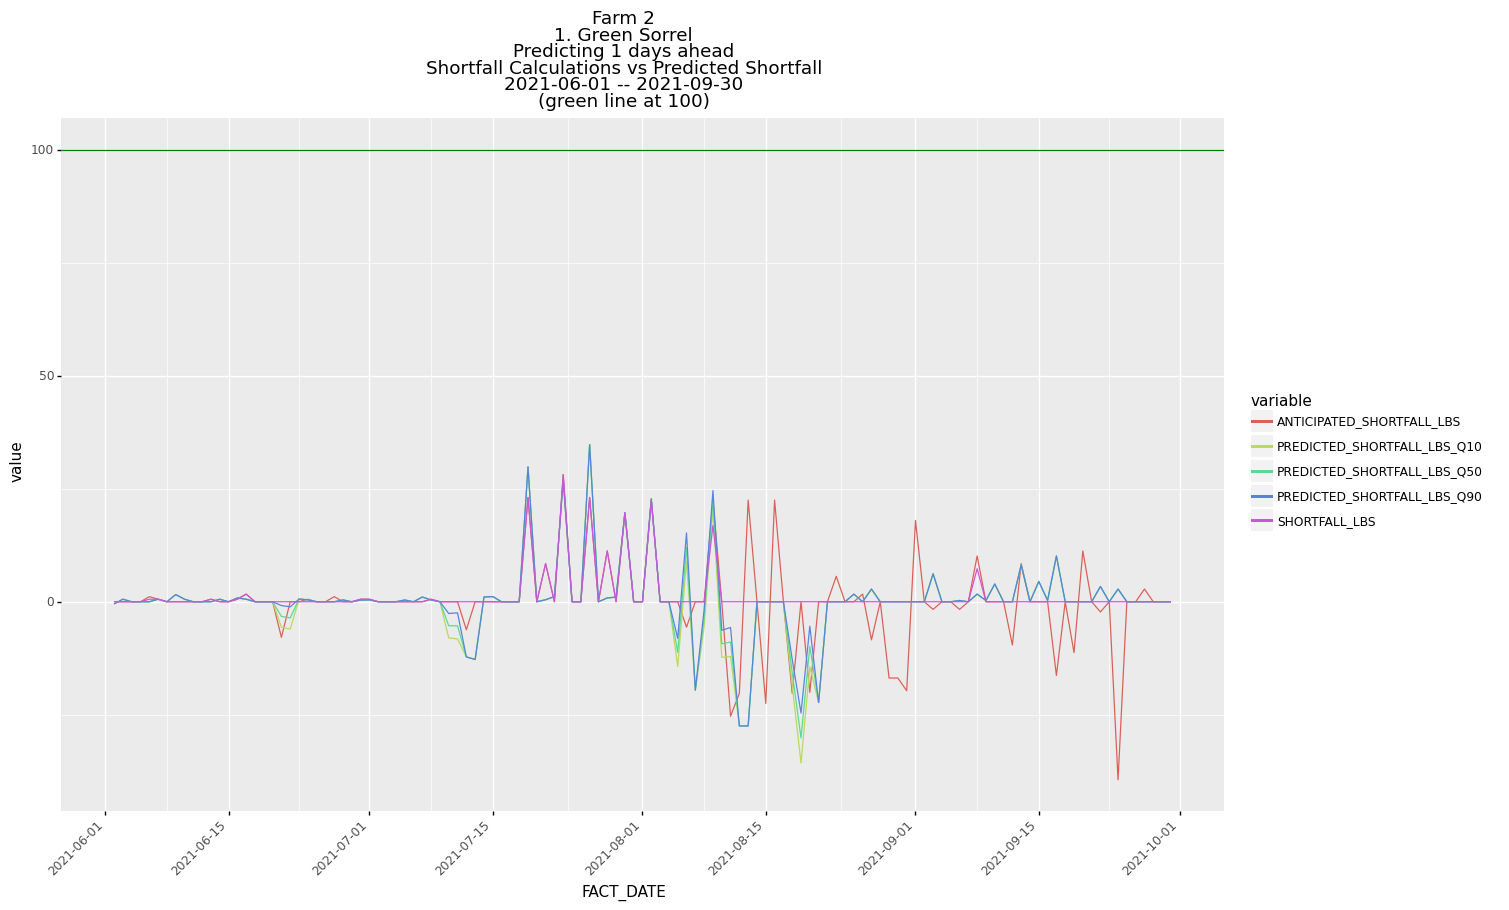

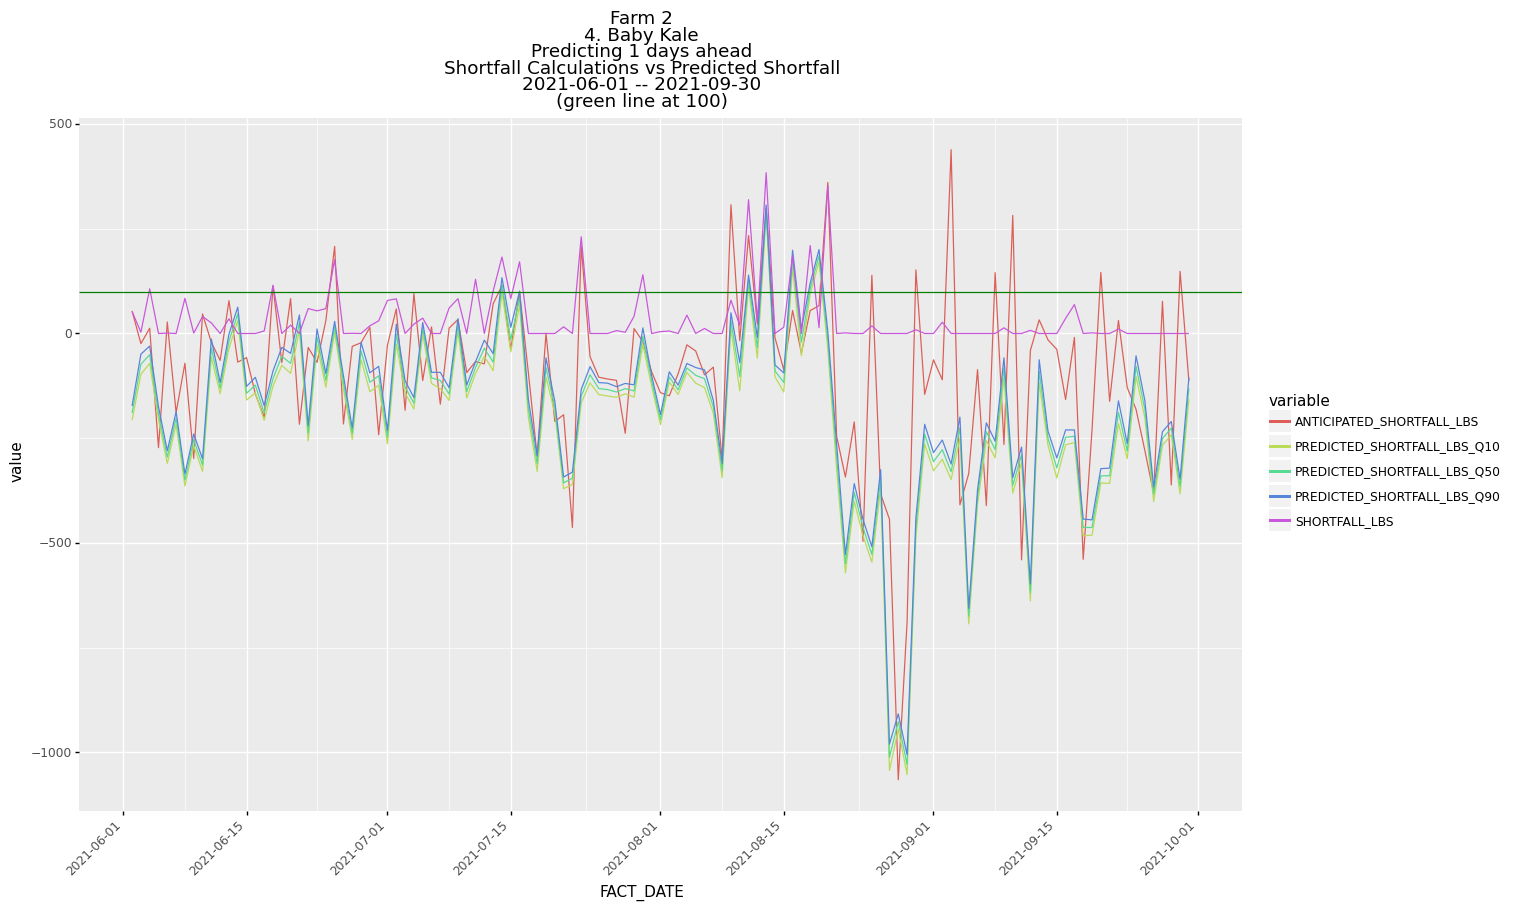

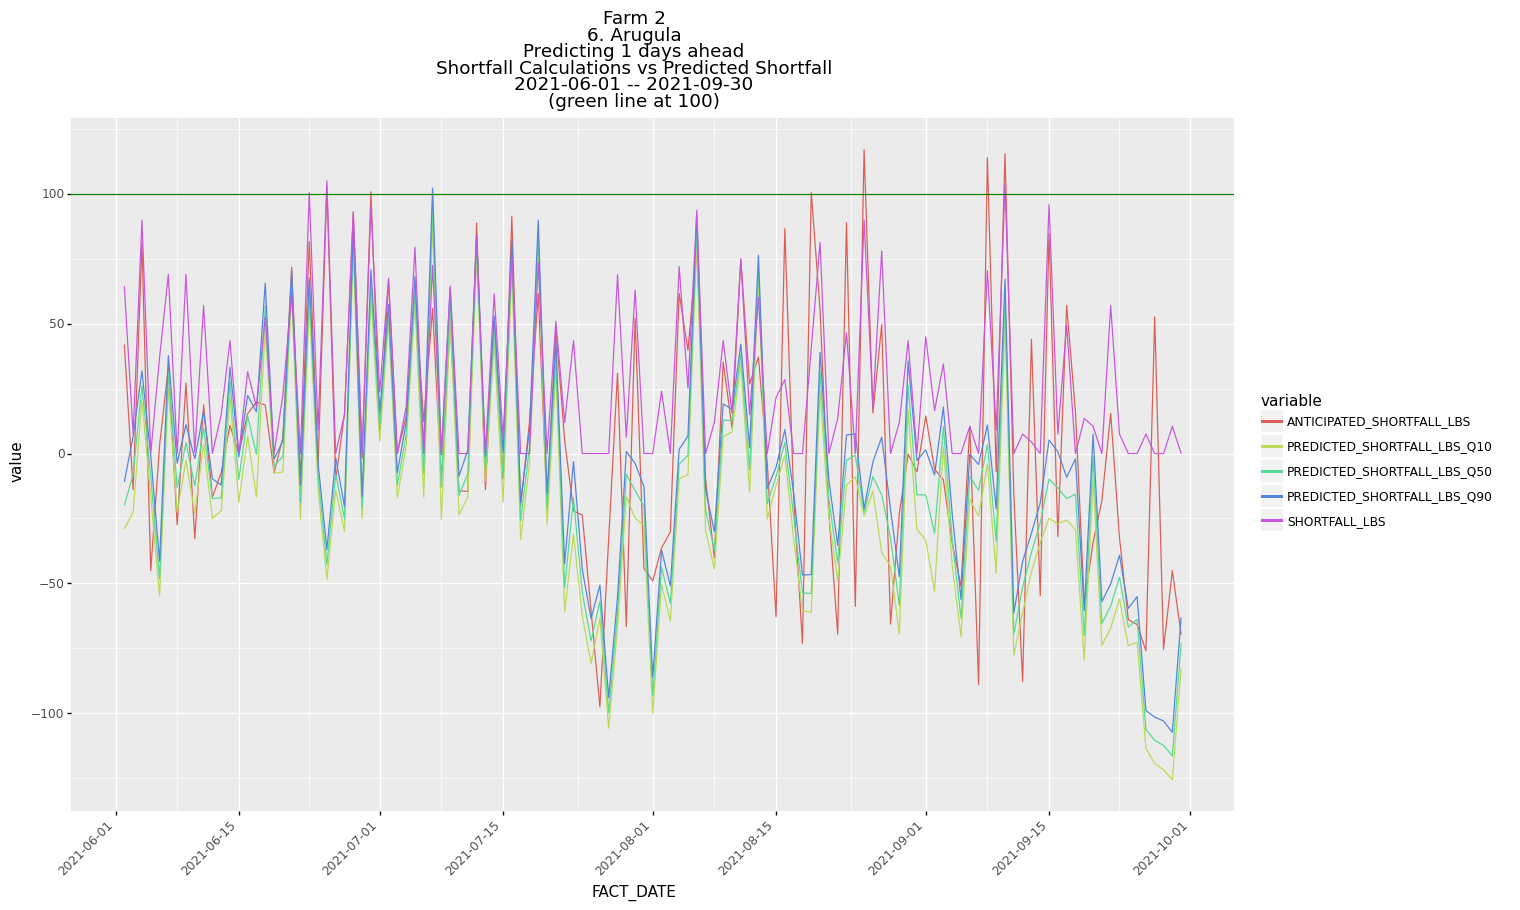

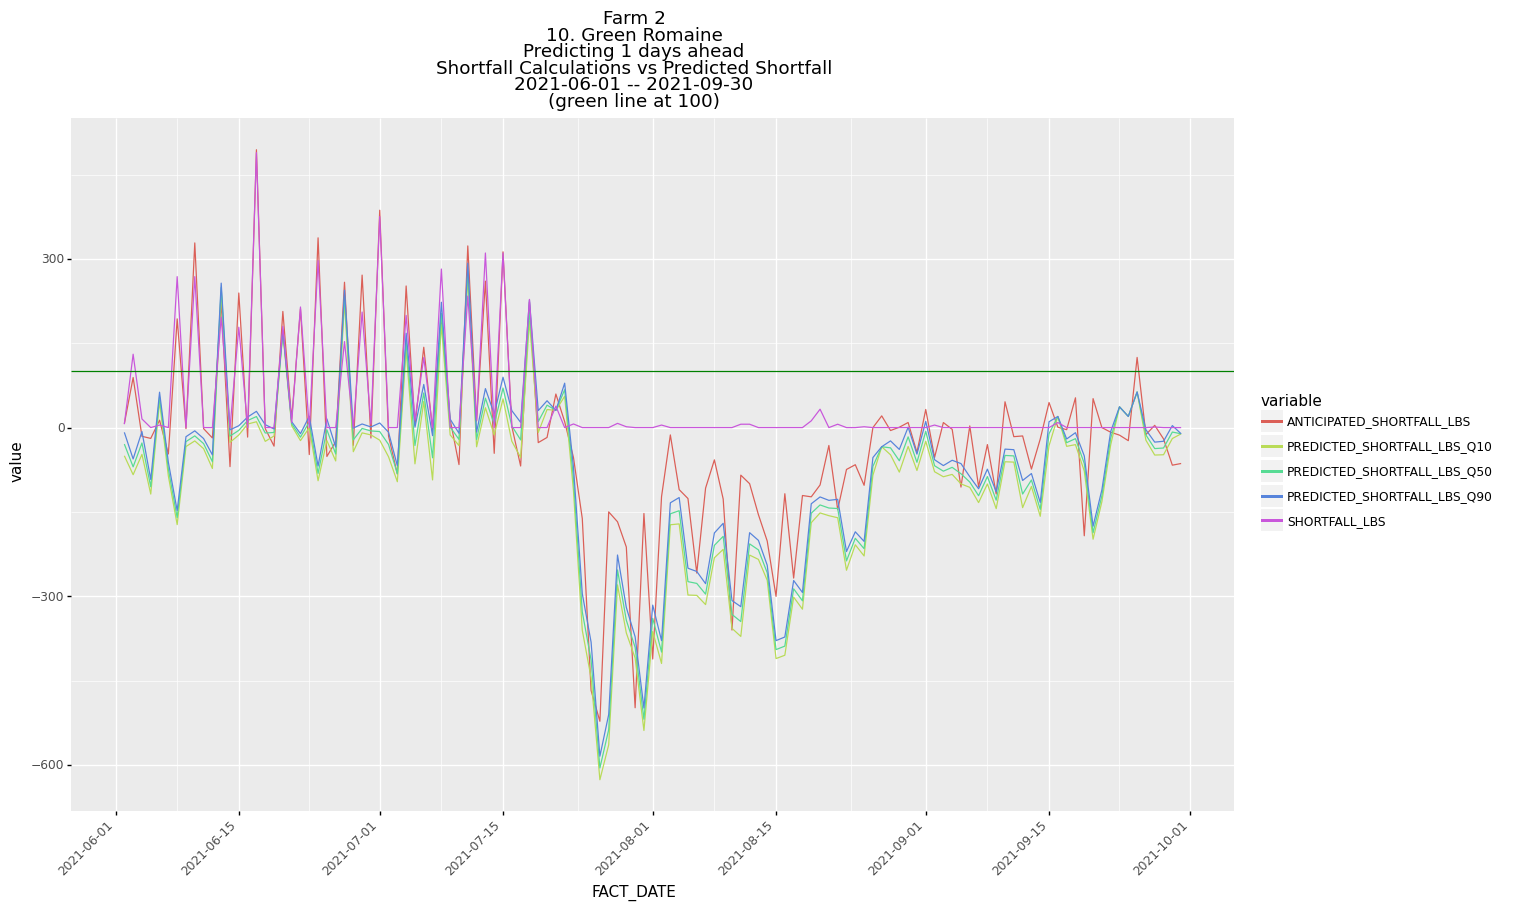

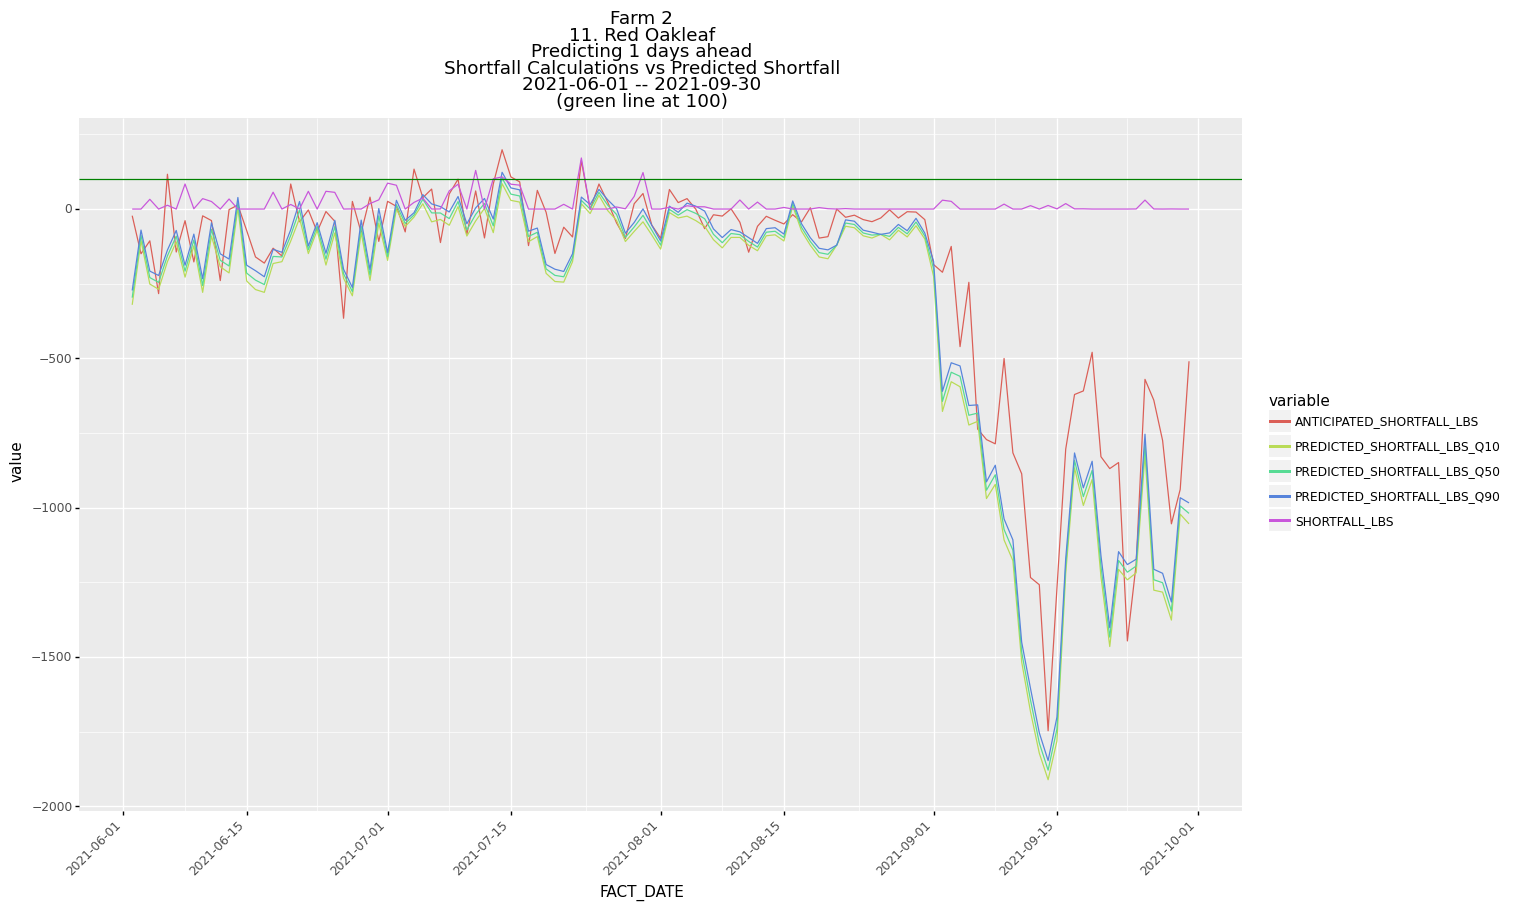

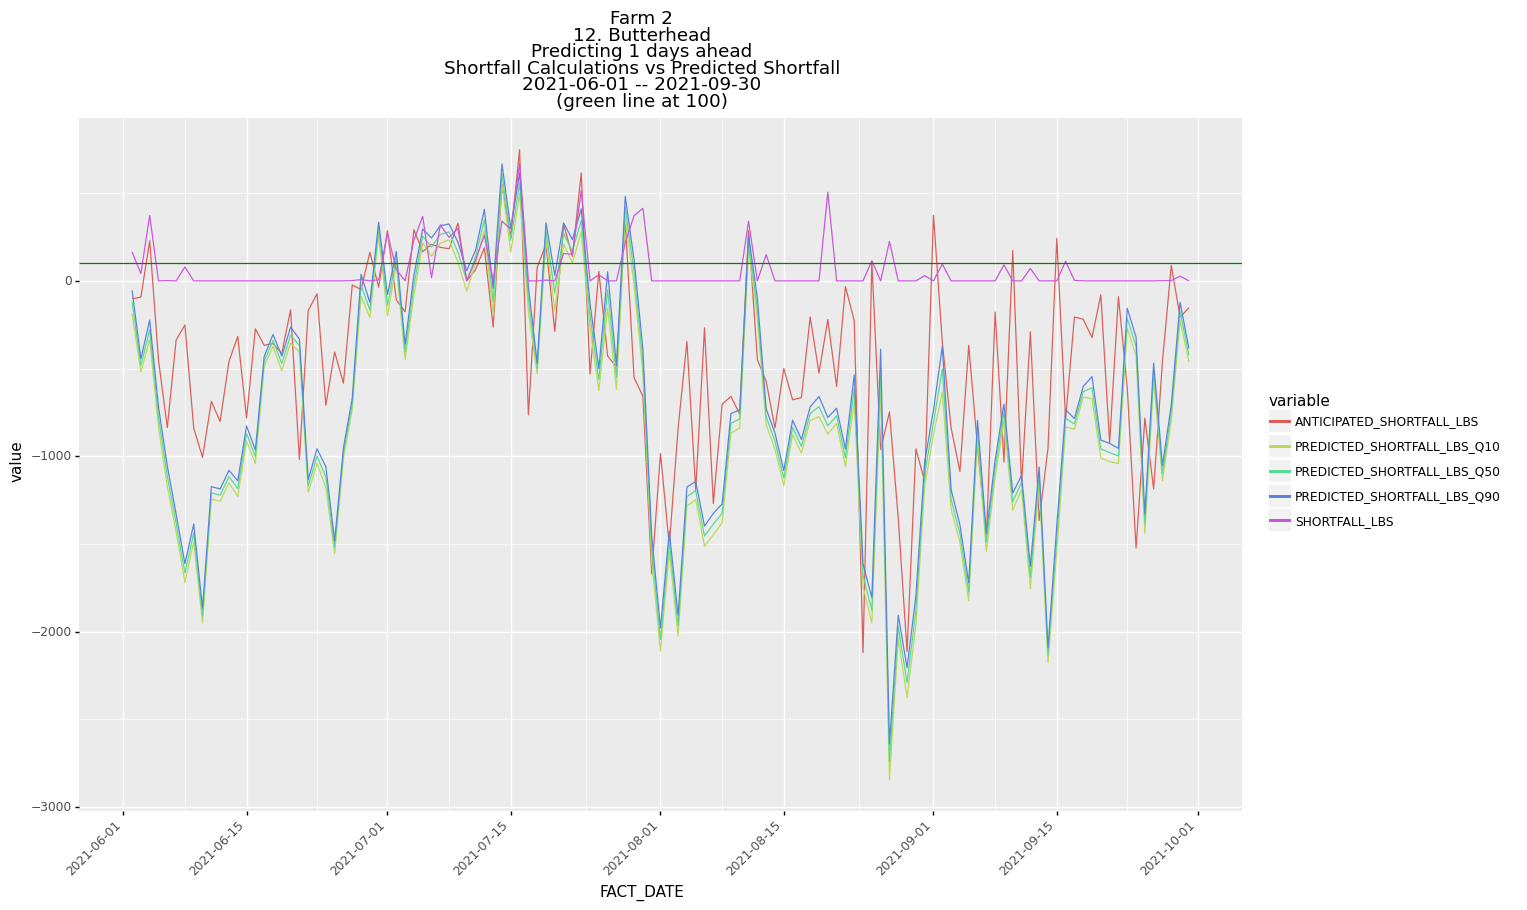

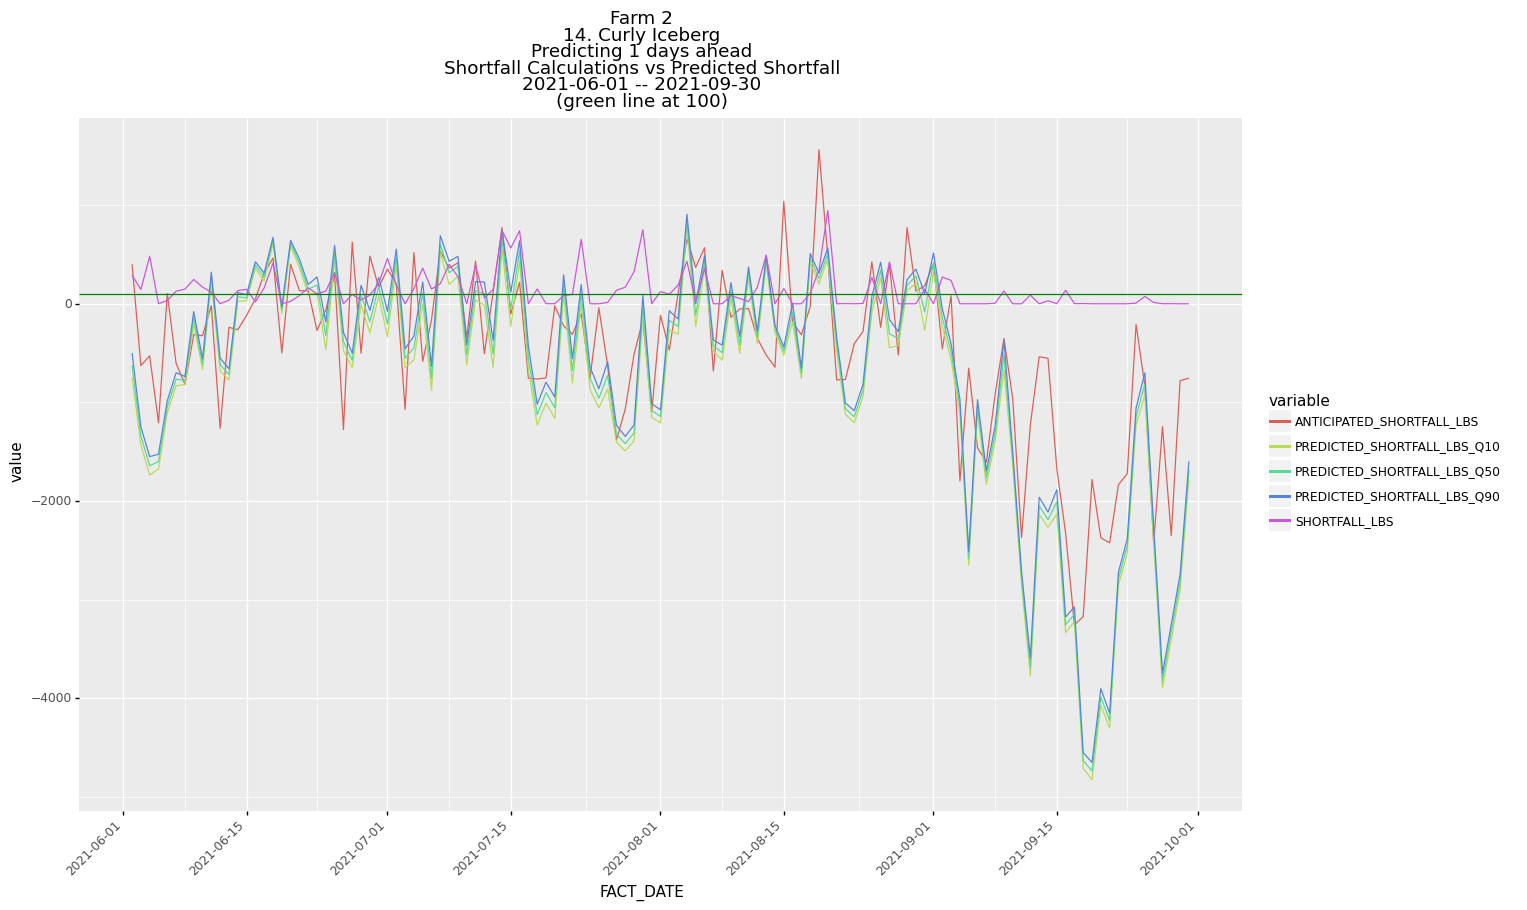

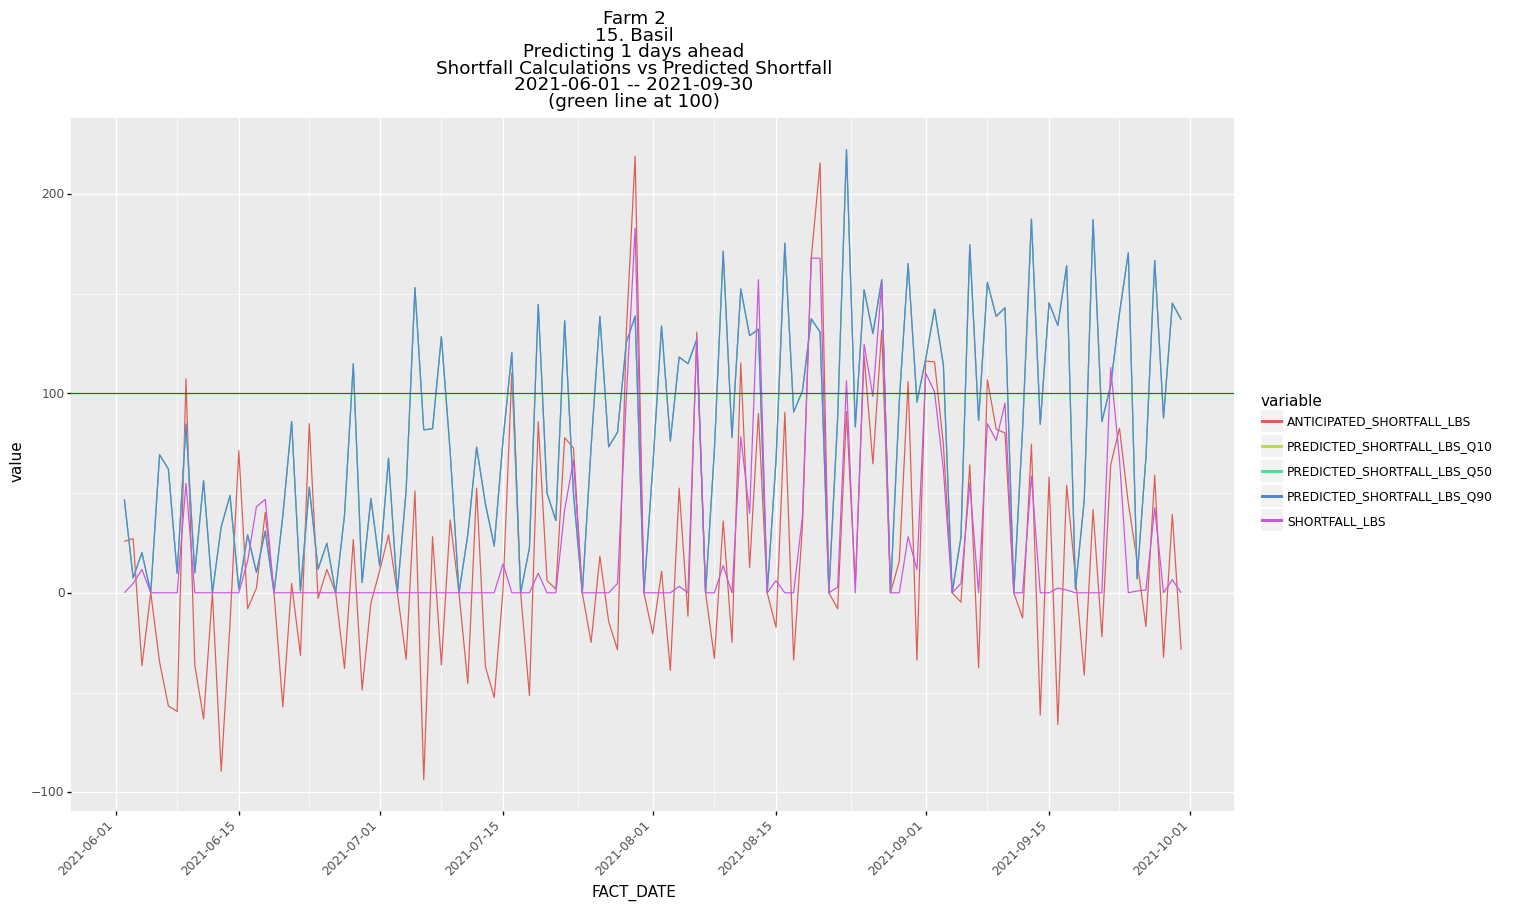

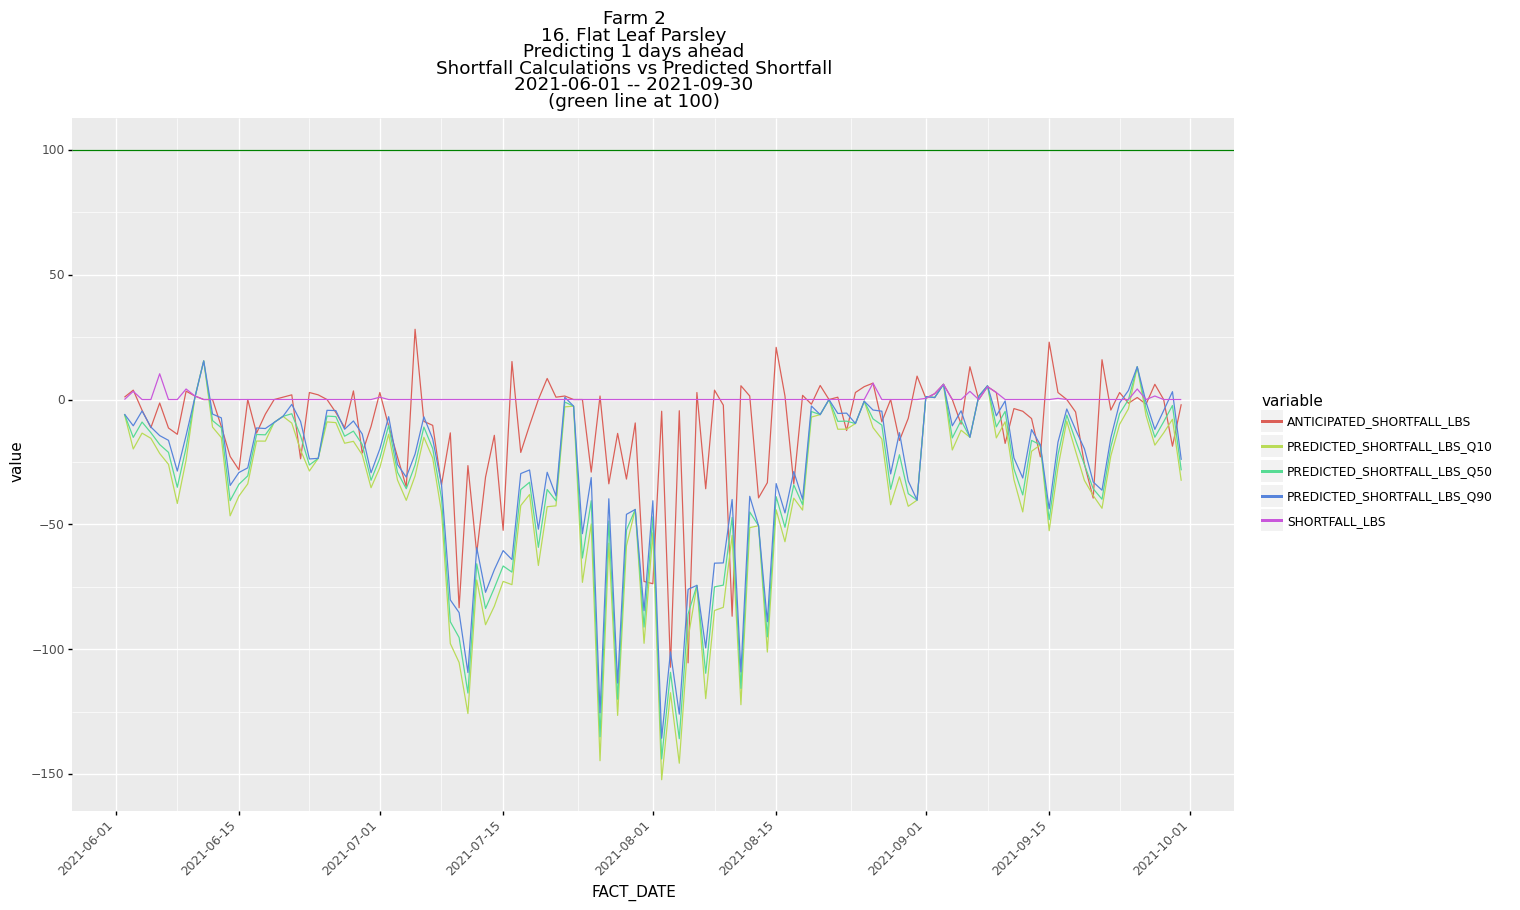

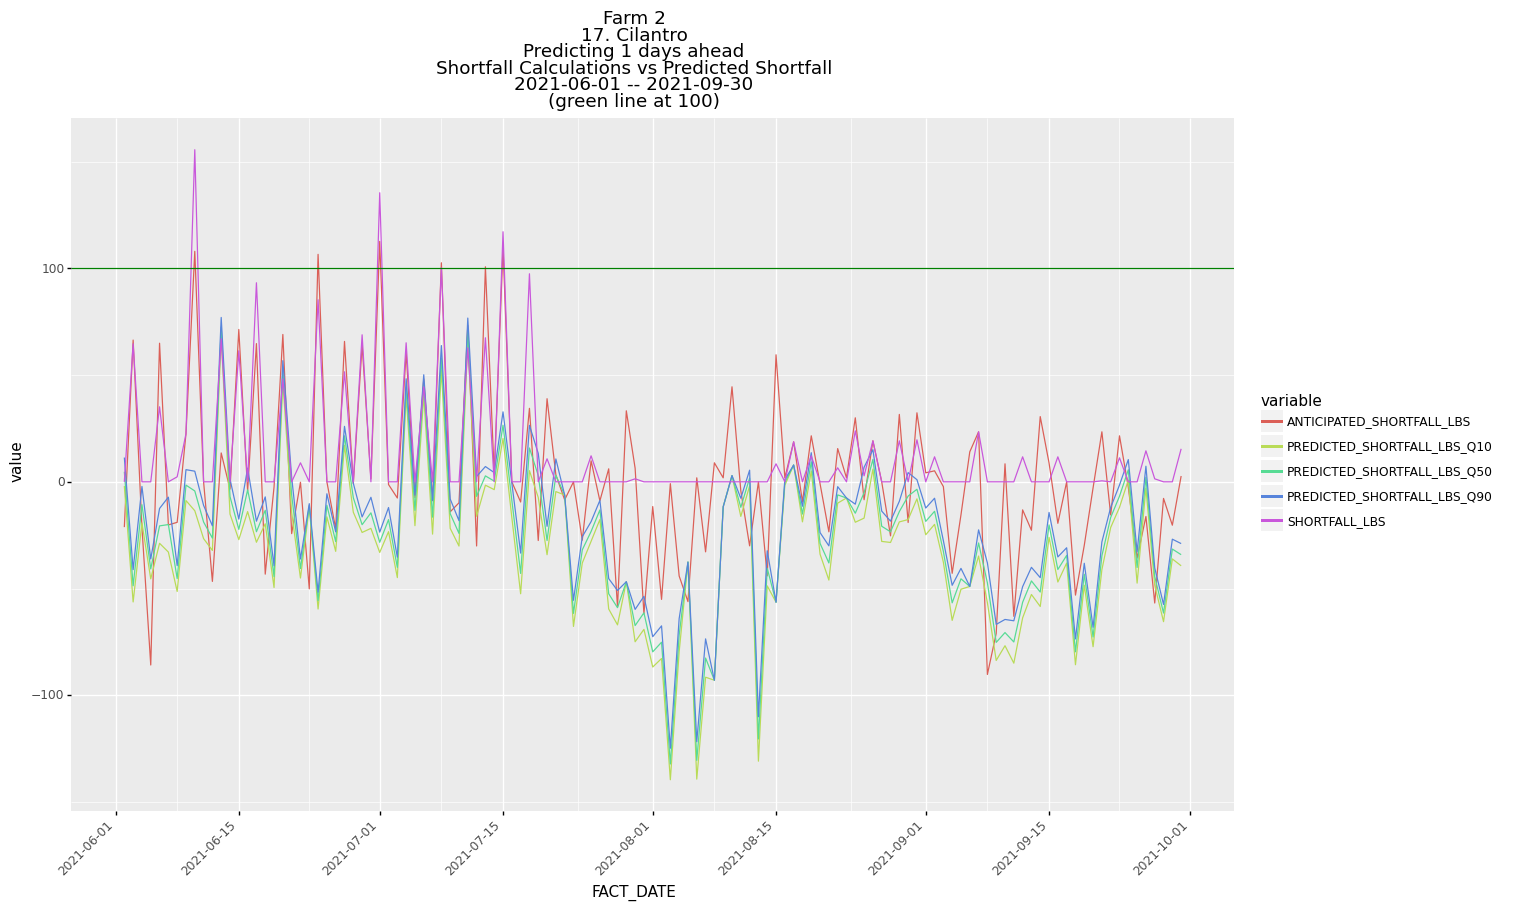

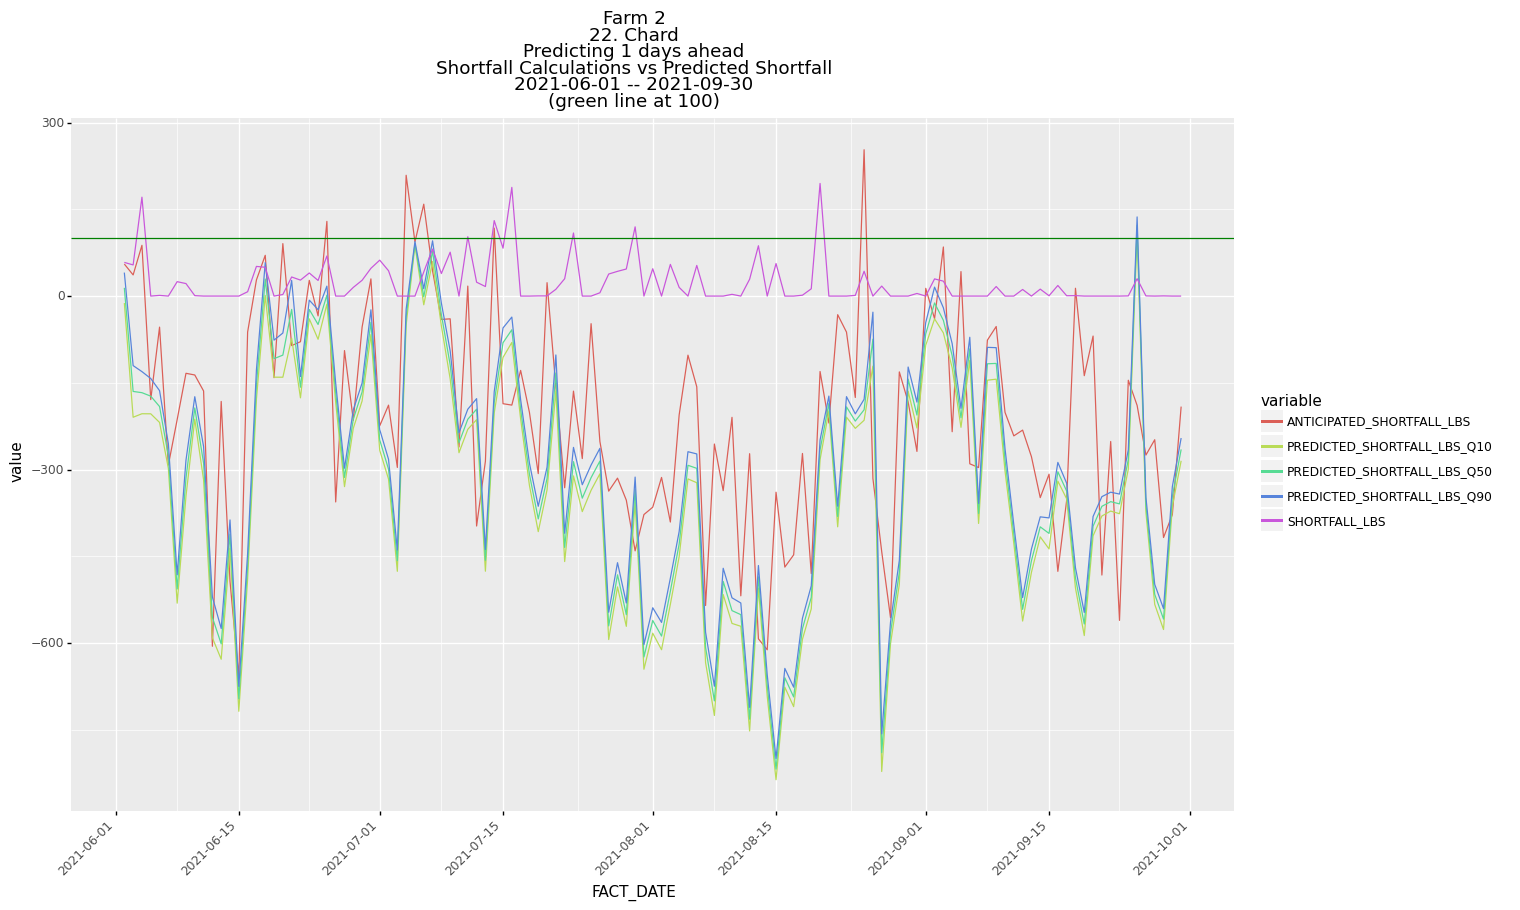

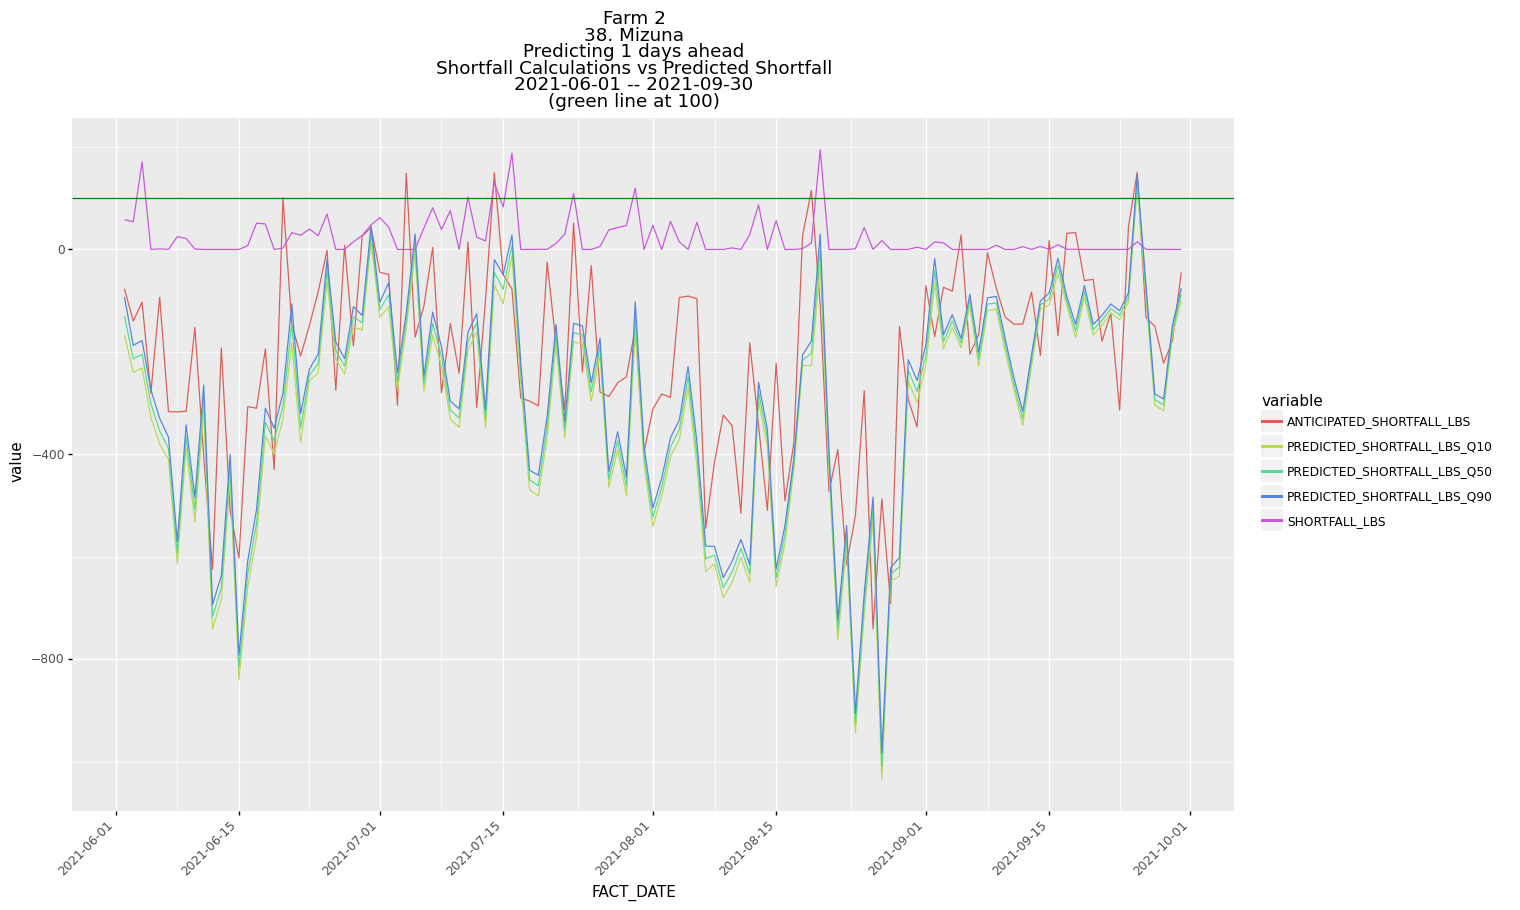

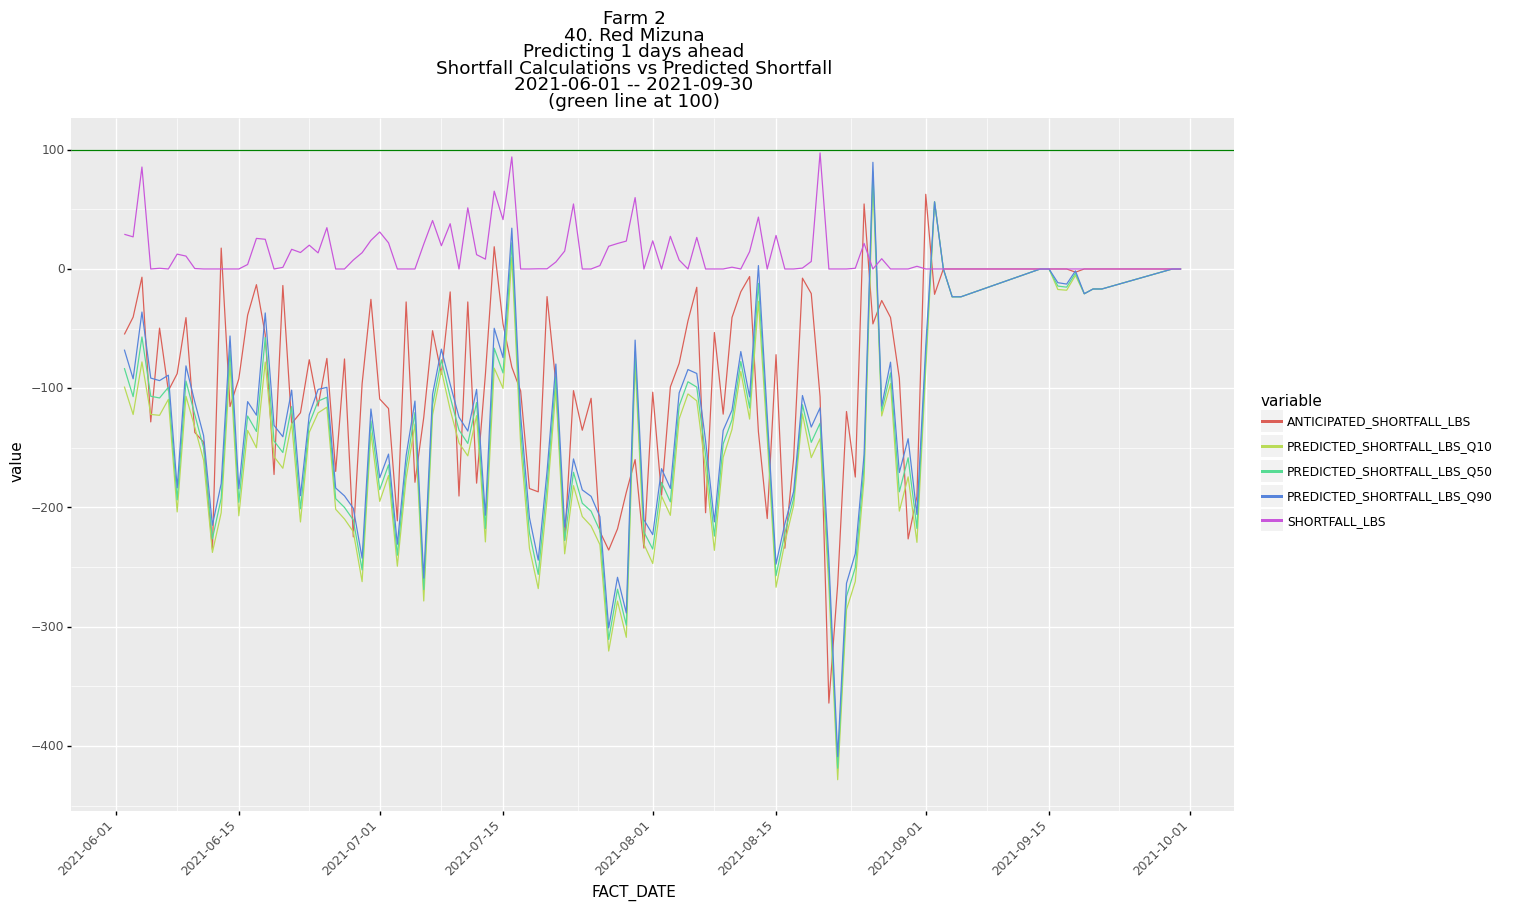

In [12]:
for p in plots:
    print(p)